In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import datasets, linear_model
import pickle
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
import numpy as np
import pystan
import pystan_utils
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct,ConstantKernel, WhiteKernel)
import time
import random
from sklearn.linear_model import LogisticRegression
import seaborn as sn
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import os
import sklearn
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import f1_score
from sklearn import decomposition
from sklearn.preprocessing import Normalizer
from sklearn import linear_model

pd.options.display.max_rows=20
pd.options.display.max_columns=200

plt.rcParams['figure.figsize'] = (15, 7)

import warnings; warnings.simplefilter('ignore')

C:\Users\User\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
model_definition = """

data {
    int<lower=1> T;                          // length of the time-series / len dwell time observed
    int<lower=0> T_forecast;                 // num. steps ahead to predict 
    real y[T];                               // time-series data / dwell times observed
    int<lower=1> D;                          // number of predictors / number of features
    matrix[(T+T_forecast),D] X;              // predictor matrix  / features without lag

}
parameters {
    real beta_y0;                            // intercepts
    vector[D] beta_y;                        // coefficients for predictors
    real<lower=0> SigmaY;                             // noise for y
} 

model {
    
    beta_y0 ~ cauchy(0,1);
    
     for (d in 1:D)
        beta_y[d] ~ cauchy(0,1);             // prior on the coefficients
    
    SigmaY ~ cauchy(0,10); 
    
    for (t in 1:T)
        y[t] ~ normal(beta_y0 + beta_y' * X[t]', SigmaY);    // likelihood
 }
    
generated quantities{
    vector[T_forecast] y_hat;          // vector to store predictions
    
    for (t in (T+1):(T+T_forecast)) {
        y_hat[t-T] = normal_rng(beta_y0 + beta_y' * X[t]', SigmaY);  // predictions    
    }
}
"""

In [3]:
def buildLaggedFeatures(s,columns, lag=336,dropna=True): #lag=3
    if type(s) is pd.DataFrame:
        new_dict={}
        for c in s.columns:
            new_dict[c]=s[c]
        for col_name in columns:
            new_dict[col_name]=s[col_name]
            # create lagged Series
            for l in range(1,lag+1):
                new_dict['%s_lag%d' %(col_name,l)]=s[col_name].shift(l)
        res=pd.DataFrame(new_dict,index=s.index)
    elif type(s) is pd.Series:
        the_range=range(lag+1)
        res=pd.concat([s.shift(i) for i in the_range],axis=1)
        res.columns=['lag_%d' %i for i in the_range]
    else:
        print('Only works for DataFrame or Series')
        return None
    if dropna:
        return res.dropna()
    else:
        return res 

    
def considered_stations(df):
    st_notConsidered=[50822,1547,28000	,900	,46743	,	1410,30941]
    station_considered=[678,  1586, 27999,30942,  7081, 27548, 28005,  715, 1365,   860 ,  1409,46743]
    list_df=[]
    for st in station_considered:
        dataf=df[df['StopPointId']==st]
        list_df.append(dataf)
    only_st_considered=pd.concat(list_df)
    try:
        only_st_considered=only_st_considered.sort_values(by='TimeStep')
    except:
        only_st_considered=only_st_considered.sort_values(by='ObservedArrivalDateTime')
    return only_st_considered

def considered_stations_dw(df):
    st_notConsidered=[50822,1547,46743	,	1410,28005,27548,46743, 30942,30941]
    station_considered=[678,  1586, 27999,  7081,     715, 1365,   860 ,  1409,900	,28000	]
    list_df=[]
    for st in station_considered:
        dataf=df[df['StopPointId']==st]
        list_df.append(dataf)
    only_st_considered=pd.concat(list_df)
    try:
        only_st_considered=only_st_considered.sort_values(by='TimeStep')
    except:
        only_st_considered=only_st_considered.sort_values(by='ObservedArrivalDateTime')
    return only_st_considered

def set_size(width, fraction=1):
    # Width of figure
    fig_width_pt = width * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27
    # Golden ratio to set aesthetic figure height
    golden_ratio = (5**.5 - 1) /1.5
    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio
    fig_dim = (fig_width_in, fig_height_in)
    return fig_dim

nice_fonts = {
        # Use LaTeX to write bol text
        "font.family": "serif",
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 9,
        "font.size": 9,
        # Make the legend/label fonts a little smboler
        "legend.fontsize": 9,
        "xtick.labelsize": 9,
        "ytick.labelsize": 9,
        "axes.titlesize": 9,
}

nice_fonts_small = {
        # Use LaTeX to write bol text
        "font.family": "serif",
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 6,
        "font.size": 6,
        # Make the legend/label fonts a little smboler
        "legend.fontsize": 6,
        "xtick.labelsize": 6,
        "ytick.labelsize": 6,
}

    

def h_after_start(df):
    df['event_during_1h_aft']=((df['Time_difference']>=-1)&(df['Time_difference']<0)&(df['event_during']>0))*1
    df['event_during_2h_aft']=((df['Time_difference']>=-2)&(df['Time_difference']<-1)&(df['event_during']>0))*1
    df['event_during_3h_aft']=((df['Time_difference']>=-3)&(df['Time_difference']<-2)&(df['event_during']>0))*1
    df['event_during_4h_aft']=((df['Time_difference']>=-4)&(df['Time_difference']<-3)&(df['event_during']>0))*1
    df['event_during_5h_aft']=((df['Time_difference']>=-5)&(df['Time_difference']<-4)&(df['event_during']>0))*1
    df['event_during_6h_aft']=((df['Time_difference']>=-6)&(df['Time_difference']<-5)&(df['event_during']>0))*1
    
    df['Temperature']=[float(i) for i in df['Temperature']]
    df['Precipitation']=[float(i) for i in df['Precipitation']]
    
    df['Entertainment']=df['Entertainment']+df['entertainment']
    df=df.drop('entertainment', 1)
    df['Classic_Music']=df['Classic_Music']+df['Classical_Music']
    df=df.drop('Classical_Music', 1)
    df['Music']=df['Music']+df['Music.1']
    df=df.drop('Music.1', 1)
    df.rename(columns={'Fælledparken': 'Outdoor_Festival'}, inplace=True)
    
    for i in range(6):
        df["H%s_%s"%(i*4,(i*4)+4)]=0
        df["H%s_%s"%(i*4,(i*4)+4)][(df['hours']>=i*4) & (df['hours']<(i*4)+4)]=1
    
    return df


def select_and_spilt(df,st,list_col_isEvent,col_y,col_x):
    df=df[df['StopPointId']==st]
    df['Temperature']=[float(i) for i in df['Temperature']]
    df['Precipitation']=[float(i) for i in df['Precipitation']]

#     for i in range(6):
#         df["H%s_%s"%(i*4,(i*4)+4)]=0
#         df["H%s_%s"%(i*4,(i*4)+4)][(df['hours']>=i*4) & (df['hours']<(i*4)+4)]=1
    
#     df['isEvent']=0
#     for col in list_col_isEvent:
#         df['isEvent']+=df[col]
    try:
        training=df[df['ObservedArrivalDateTime'].dt.month<9]
        test=df[df['ObservedArrivalDateTime'].dt.month>8]
    except:
        training=df[df['TimeStep'].dt.month<4]
        test=df[df['TimeStep'].dt.month>3]
    test.reset_index(inplace=True,drop=True)
    y_test=np.array(test[col_y], ndmin=2).T
    y_training=np.array(training[col_y], ndmin=2).T
    col_x=col_x+list_col_isEvent
    x_training=training[training.columns.intersection(col_x)]
    x_test=test[test.columns.intersection(col_x)]
    return training, test, y_test,y_training,x_training,x_test



def historical_average_good(training,col_y,test):
    historical_average=[None] * len(test)
    historical_average=np.array(historical_average)
    #saturday
    historical_average[(test['day']==5) & (test['hours']>=0)& (test['hours']<4)]=training[col_y][(training['day']==5) & (training['hours']>=0)& (training['hours']<4)].mean()
    historical_average[(test['day']==5) & (test['hours']>=4)& (test['hours']<7)]=training[col_y][(training['day']==5) & (training['hours']>=4)& (training['hours']<7)].mean()
    historical_average[(test['day']==5) & (test['hours']>=7)& (test['hours']<9)]=training[col_y][(training['day']==5) & (training['hours']>=7)& (training['hours']<9)].mean()
    historical_average[(test['day']==5) & (test['hours']>=9)& (test['hours']<15)]=training[col_y][(training['day']==5) & (training['hours']>=9)& (training['hours']<15)].mean()
    historical_average[(test['day']==5) & (test['hours']>=15)& (test['hours']<18)]=training[col_y][(training['day']==5) & (training['hours']>=15)& (training['hours']<18)].mean()
    historical_average[(test['day']==5) & (test['hours']>=18)& (test['hours']<24)]=training[col_y][(training['day']==5) & (training['hours']>=18)& (training['hours']<24)].mean()
    #sunday
    historical_average[(test['day']==6) & (test['hours']>=0)& (test['hours']<4)]=training[col_y][(training['day']==6) & (training['hours']>=0)& (training['hours']<4)].mean()
    historical_average[(test['day']==6) & (test['hours']>=4)& (test['hours']<7)]=training[col_y][(training['day']==6) & (training['hours']>=4)& (training['hours']<7)].mean()
    historical_average[(test['day']==6) & (test['hours']>=7)& (test['hours']<9)]=training[col_y][(training['day']==6) & (training['hours']>=7)& (training['hours']<9)].mean()
    historical_average[(test['day']==6) & (test['hours']>=9)& (test['hours']<15)]=training[col_y][(training['day']==6) & (training['hours']>=9)& (training['hours']<15)].mean()
    historical_average[(test['day']==6) & (test['hours']>=15)& (test['hours']<18)]=training[col_y][(training['day']==6) & (training['hours']>=15)& (training['hours']<18)].mean()
    historical_average[(test['day']==6) & (test['hours']>=18)& (test['hours']<24)]=training[col_y][(training['day']==6) & (training['hours']>=18)& (training['hours']<24)].mean()
    #weekday
    historical_average[(test['day']<5) & (test['hours']>=0)& (test['hours']<4)]=training[col_y][(training['day']<5) & (training['hours']>=0)& (training['hours']<4)].mean()
    historical_average[(test['day']<5) & (test['hours']>=4)& (test['hours']<7)]=training[col_y][(training['day']<5) & (training['hours']>=4)& (training['hours']<7)].mean()
    historical_average[(test['day']<5) & (test['hours']>=7)& (test['hours']<9)]=training[col_y][(training['day']<5) & (training['hours']>=7)& (training['hours']<9)].mean()
    historical_average[(test['day']<5) & (test['hours']>=9)& (test['hours']<15)]=training[col_y][(training['day']<5) & (training['hours']>=9)& (training['hours']<15)].mean()
    historical_average[(test['day']<5) & (test['hours']>=15)& (test['hours']<18)]=training[col_y][(training['day']<5) & (training['hours']>=15)& (training['hours']<18)].mean()
    historical_average[(test['day']<5) & (test['hours']>=18)& (test['hours']<24)]=training[col_y][(training['day']<5) & (training['hours']>=18)& (training['hours']<24)].mean()
    return historical_average


def historical_average_poor(training,col_y,test):
    historical_average=[training[col_y].mean().values[0]] * len(test)
#     index_test=test_inde.index[test_inde['isEvent']>0] ining[col_y].mean().values[0]] * len(test)
    return historical_average


def linear_regression(x_training,x_test,y_training ):
    start_time = time.clock()
    x_training=np.c_[np.ones(len(x_training)),x_training]
    x_test=np.c_[np.ones(len(x_test)),x_test]
    regr=linear_model.LinearRegression(fit_intercept=False)   
    regr.fit(x_training, y_training.T);
    y_pred_lr=regr.predict(x_test)
    y_pred_lr[y_pred_lr<=1]=1
    print(round((time.clock() - start_time)/60), "minutes")
    return y_pred_lr


def gaussian_process(al_n,st,list_col_isEvent,col_y,col_x ):
    training, test, y_test,y_training,x_training,x_test=select_and_spilt(al_n,st,list_col_isEvent,col_y,col_x)
    start_time = time.clock()
    gp = GaussianProcessRegressor()
    gp.fit(x_training, y_training[0])
    y_pred_gp = gp.predict(x_test, return_std=False)   
    y_pred_gp[y_pred_gp<=1]=1
#     y_pred_gp[y_pred_gp>30]=30
    print(round((time.clock() - start_time)/60), "minutes")
    return y_pred_gp


def baysian_inference(x_training,x_test,y_training,baysian_type):
    start_time = time.clock()
    X=np.concatenate((x_training,x_test),axis=0)
    N, D = X.shape
    data = {'T': len(x_training), 'T_forecast': len(x_test), 'y': y_training[0,:].T,'D': D, 'X': X }
    if baysian_type=="ADVI":
        sm = pystan.StanModel(model_code=model_definition)
        fit = sm.vb(data=data, iter=20000, algorithm="meanfield", grad_samples=10, verbose=True)
        y_hat = pystan_utils.vb_extract_variable(fit, "y_hat", var_type="vector")
    if baysian_type=="MCMC":
        sm = pystan.StanModel(model_code=model_definition)
        fit = sm.sampling(data=data, iter=1000, chains=4, algorithm="NUTS",  verbose=True)
        samples = fit.extract(permuted=True)  # return a dictionary of arrays
        y_hat = samples["y_hat"].mean(axis=0)
        check_convergence(fit)
    y_hat[y_hat<=1]=1
    print(round((time.clock() - start_time)/60), "minutes")
    return y_hat


def compute_error(trues, predicted):
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 =  1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2)
    return mae, rae, rmse, r2


def errors_table_event(y_test,hist_average,y_pred_lr,y_hat,y_pred_gp,st,test):
    test_inde=test.reset_index()
    index_test=test_inde.index[test_inde['isEvent']>0] 
    mae, rae, rmse, r2 = compute_error(y_test[0,:][index_test], np.array(hist_average)[index_test])
    errors=pd.DataFrame({'Model': ["Historical Average"], 'mae': [round(mae,2)],'rae': [round(rae,2)],'rmse': [round(rmse,2)],  'r2': [round(r2,2)]   })
    mae, rae, rmse, r2=compute_error(y_test[0,:][index_test], y_pred_lr[:,0][index_test])
    errors=errors.append(pd.DataFrame({'Model': ["Linear Regression"], 'mae': [round(mae,2)],'rae': [round(rae,2)],'rmse': [round(rmse,2)],  'r2': [round(r2,2)]   }))
    mae, rae, rmse, r2 = compute_error(y_test[0,:][index_test], y_hat[index_test])
    errors=errors.append(pd.DataFrame({'Model': ["Bayesian Inference"], 'mae': [round(mae,2)],'rae': [round(rae,2)],'rmse': [round(rmse,2)],  'r2': [round(r2,2)]   }))
    mae, rae, rmse, r2 = compute_error(y_test[0,:][index_test],y_pred_gp[index_test])
    errors=errors.append(pd.DataFrame({'Model': ["Gaussian Process"], 'mae': [round(mae,2)],'rae': [round(rae,2)],'rmse': [round(rmse,2)],  'r2': [round(r2,2)]   }))
    print("ev",errors)
    errors.to_csv("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\ErrorsTable_event\\%s_%s.csv"%(st,col_y[0]))

    
def errors_table_all(y_test,hist_average,y_pred_lr,y_hat,y_pred_gp,st,test):
    mae, rae, rmse, r2 = compute_error(y_test[0,:], hist_average)
    
    errors=pd.DataFrame({'Model': ["Historical Average"], 'mae': [round(mae,2)],'rae': [round(rae,2)],'rmse': [round(rmse,2)],  'r2': [round(r2,2)]   })
    mae, rae, rmse, r2=compute_error(y_test[0,:], y_pred_lr[:,0])
    errors=errors.append(pd.DataFrame({'Model': ["Linear Regression"], 'mae': [round(mae,2)],'rae': [round(rae,2)],'rmse': [round(rmse,2)],  'r2': [round(r2,2)]   }))
    mae, rae, rmse, r2 = compute_error(y_test[0,:], y_hat)
    errors=errors.append(pd.DataFrame({'Model': ["Bayesian Inference"], 'mae': [round(mae,2)],'rae': [round(rae,2)],'rmse': [round(rmse,2)],  'r2': [round(r2,2)]   }))
    mae, rae, rmse, r2 = compute_error(y_test[0,:],y_pred_gp)
    errors=errors.append(pd.DataFrame({'Model': ["Gaussian Process"], 'mae': [round(mae,2)],'rae': [round(rae,2)],'rmse': [round(rmse,2)],  'r2': [round(r2,2)]   }))
    print("all",errors)
    errors.to_csv("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\ErrorsTable_all\\%s_errors_%s.csv"%(st,col_y[0]))


def box_plotting_event(y_test, y_hat, y_pred_lr, hist_average, y_pred_gp,test,st):
    plt.rcParams['figure.figsize'] = (8, 4)
    diffHA=hist_average-y_test
    diffLR=y_pred_lr-y_test
    diffGP=y_pred_gp-y_test
    diffBA=y_hat-y_test
    
    test_inde=test.reset_index()
    index_test=test_inde.index[test_inde['isEvent']>0] 
    
    Min=int(min(min(diffHA[0][index_test]),min(diffLR[0][index_test]),min(diffGP[0][index_test]),min(diffBA[0][index_test])))-5
    Max=int(max(max(diffHA[0][index_test]),max(diffLR[0][index_test]),max(diffGP[0][index_test]),max(diffBA[0][index_test])))+5
    plt.subplot2grid((1,4),(0,0))
    plt.boxplot(diffHA[0][index_test])
    plt.title("Historical average")
    plt.ylim(Min,Max)
    plt.axhline(0,c="k",alpha=0.5,ls="--")
    plt.subplot2grid((1,4),(0,1))
    plt.boxplot(diffLR[0][index_test])
    plt.title("Linear Regression")
    plt.ylim(Min,Max)
    plt.axhline(0,c="k",alpha=0.5,ls="--")
    plt.subplot2grid((1,4),(0,2))
    plt.boxplot(diffGP[0][index_test])
    plt.title("Gaussian Process")
    plt.ylim(Min,Max)
    plt.axhline(0,c="k",alpha=0.5,ls="--")
    plt.subplot2grid((1,4),(0,3))
    plt.boxplot(diffBA[0][index_test])
    plt.title("Bayesian Inference")
    plt.ylim(Min,Max)
    plt.axhline(0,c="k",alpha=0.5,ls="--")
    
    file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\pdf_box\\"%(st,col_y[0])
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\png_box\\"%(st,col_y[0])
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\svg_box\\"%(st,col_y[0])
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\pdf_box\\%s_BOX_Event.pdf"%(st,col_y[0],st), format='pdf', bbox_inches='tight')
    plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\png_box\\%s_BOX_Event.png"%(st,col_y[0],st), format='png', bbox_inches='tight')
    plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\svg_box\\%s_BOX_Event.svg"%(st,col_y[0],st), format='svg', bbox_inches='tight')
    plt.show()


def box_plotting(y_test, y_hat, y_pred_lr, hist_average, y_pred_gp,test,st):   
    plt.rcParams['figure.figsize'] = (8, 4)
    
    diffHA=hist_average-y_test
    diffLR=y_pred_lr[:,0]-y_test
    diffGP=y_pred_gp-y_test
    diffBA=y_hat-y_test
    Min=int(min(min(diffHA[0]),min(diffLR[0]),min(diffGP[0]),min(diffBA[0])))-5
    Max=int(max(max(diffHA[0]),max(diffLR[0]),max(diffGP[0]),max(diffBA[0])))+5
    plt.subplot2grid((1,4),(0,0))
    plt.boxplot(diffHA[0])
    plt.title("Historical average")
    plt.ylim(Min,Max)
    plt.axhline(0,c="k",alpha=0.5,ls="--")
    plt.subplot2grid((1,4),(0,1))
    plt.boxplot(diffLR[0])
    plt.title("Linear Regression")
    plt.ylim(Min,Max)
    plt.axhline(0,c="k",alpha=0.5,ls="--")
    plt.subplot2grid((1,4),(0,2))
    plt.boxplot(diffGP[0])
    plt.title("Gaussian Process")
    plt.ylim(Min,Max)
    plt.axhline(0,c="k",alpha=0.5,ls="--")
    plt.subplot2grid((1,4),(0,3))
    plt.boxplot(diffBA[0])
    plt.title("Bayesian Inference")
    plt.ylim(Min,Max)
    plt.axhline(0,c="k",alpha=0.5,ls="--")
    
    file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\pdf_box\\"%(st,col_y[0])
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\png_box\\"%(st,col_y[0])
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\svg_box\\"%(st,col_y[0])
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\pdf_box\\%s_BOX.pdf"%(st,col_y[0],st), format='pdf', bbox_inches='tight')
    plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\png_box\\%s_BOX.png"%(st,col_y[0],st), format='png', bbox_inches='tight')
    plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\svg_box\\%s_BOX.svg"%(st,col_y[0],st), format='svg', bbox_inches='tight')
    plt.show()


def plotting_unique(y_test, y_hat, y_pred_lr, hist_average, y_pred_gp,test,st,ev):
    plt.rcParams['figure.figsize'] = (8, 4)
    ev=ev[ev['venue_unique']==test.PoiName.unique()[0]]
    ev=ev[ev['starting_time'].dt.month>=test.TimeStep.dt.month[0]]
    for date in ev.starting_time:
        da=date.day
        mo=date.month
        ho=date.hour

        test_inde=test.reset_index()
        indexs=test_inde.index[(test['TimeStep'].dt.month==mo) & (test['TimeStep'].dt.day==da)] 
        if len(indexs)>0:
            plt.axvline(ho,c="k",linestyle=(0, (1, 5)))
            H_min=test.iloc[indexs].hours+(test.iloc[indexs].TimeStep.dt.minute)/60
            plt.plot(H_min,y_test[0][indexs],c="k", label="True",linewidth=0.8)
            plt.plot(H_min,y_pred_gp[indexs],linestyle=':',c="k",color="m",label="Gaussian Process",linewidth=0.8)
            plt.plot(H_min,y_hat[indexs],'--*',color="C4",label="Bayesian Inference",linewidth=0.8)
            plt.plot(H_min,y_pred_lr[indexs],linestyle='-.',color="C1",label="Linear regression",linewidth=0.8)
            plt.plot(H_min,np.array(hist_average)[indexs],linestyle="--",color="C6",label="Historical average",linewidth=0.8)
            plt.rcParams['axes.facecolor']='white'
            plt.rcParams['savefig.facecolor']='white'
            plt.legend(loc=2)
            plt.xticks(range(25))
            plt.grid(b=True,c="grey",alpha=0.2,linewidth=0.2)
            plt.title("Prediction on %s/%s/2017"%(mo,da))
            plt.ylabel("%s"%(col_y[0]))
            plt.xlabel("Hours")

            file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\pdf_single_plot\\"%(st,col_y[0])
            directory = os.path.dirname(file_path)
            if not os.path.exists(directory):
                os.makedirs(directory)
            file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\png_single_plot\\"%(st,col_y[0])
            directory = os.path.dirname(file_path)
            if not os.path.exists(directory):
                os.makedirs(directory)
            file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\svg_single_plot\\"%(st,col_y[0])
            directory = os.path.dirname(file_path)
            if not os.path.exists(directory):
                os.makedirs(directory)

            plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\pdf_single_plot\\%s_%s.pdf"%(st,col_y[0],mo,da), format='pdf', bbox_inches='tight')
            plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\png_single_plot\\%s_%s.png"%(st,col_y[0],mo,da), format='png', bbox_inches='tight')
            plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\svg_single_plot\\%s_%s.svg"%(st,col_y[0],mo,da), format='svg', bbox_inches='tight')
            plt.show()
            
            
def plotting_45degree(y_test, y_hat, y_pred_lr, hist_average, y_pred_gp,test,st,ev):          
    models=[np.array(hist_average),y_pred_lr[:,0],y_pred_gp,y_hat]
    labels=["---","Historical Average","Linear Regression", "Gaussian Process","Bayesian Inference"]
    i =0
    for mo in models:
        i+=1
        plt.rcParams['figure.figsize'] = (6, 6)
        plt.scatter(y_test[0],mo,s=10)
        yLim=max(y_test[0])
        plt.ylim(-2,yLim+2)
        plt.xlim(-2,yLim+2)
        plt.plot([-2,yLim+2], [-2,yLim+2], ls="--", c=".3",alpha=0.5)
        plt.xlabel("True")
        plt.ylabel("%s"%(labels[i]))
        plt.title("True values - Forecast")
        
        
        file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\pdf_45Degree\\"%(st,col_y[0])
        directory = os.path.dirname(file_path)
        if not os.path.exists(directory):
            os.makedirs(directory)
        file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\png_45Degree\\"%(st,col_y[0])
        directory = os.path.dirname(file_path)
        if not os.path.exists(directory):
            os.makedirs(directory)
        file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\svg_45Degree\\"%(st,col_y[0])
        directory = os.path.dirname(file_path)
        if not os.path.exists(directory):
            os.makedirs(directory)

        plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\pdf_45Degree\\%s_%s.pdf"%(st,col_y[0],st,col_y[0]), format='pdf', bbox_inches='tight')
        plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\png_45Degree\\%s_%s.png"%(st,col_y[0],st,col_y[0]), format='png', bbox_inches='tight')
        plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\svg_45Degree\\%s_%s.svg"%(st,col_y[0],st,col_y[0]), format='svg', bbox_inches='tight')
        plt.show()

            
def plotting_multiple(y_test, y_hat, y_pred_lr, hist_average, y_pred_gp,test,st,ev):
    plt.rcParams['figure.figsize'] = (10, 25)
    ev=ev[ev['venue_unique']==test.PoiName.unique()[0]]
    ev=ev[ev['starting_time'].dt.month>=test.TimeStep.dt.month[0]]
    for date in ev.starting_time:
        da=date.day
        mo=date.month
        ho=date.hour
        test_inde=test.reset_index()
        indexs=test_inde.index[(test['TimeStep'].dt.month==mo) & (test['TimeStep'].dt.day==da)] 
        if len(indexs)>0:
            models=[np.array(hist_average)[indexs],y_pred_lr[indexs],y_pred_gp[indexs],y_hat[indexs]]
            labels=["---","Historical Average","Linear Regression", "Gaussian Process","Bayesian Inference"]
            palette = plt.get_cmap('Set1')
            num=0
            H_min=test.iloc[indexs].hours+(test.iloc[indexs].TimeStep.dt.minute)/60
            for column in models:
                num+=1
                plt.subplot(5,1, num)
                plt.rcParams['axes.facecolor']='white'
                plt.rcParams['savefig.facecolor']='white'
                for col in models:
                    plt.plot(H_min,col, marker='', color='grey', linewidth=0.6, alpha=0.5)
                plt.plot(H_min,column, marker='', color=palette(num), linewidth=2.4, alpha=0.9, label=labels[num])
                plt.plot(H_min,y_test[0][indexs], marker='', color="black", linewidth=2.4, alpha=0.5, label="True")
                plt.axvline(ho,c="k",linestyle=':')
                plt.legend(loc=2)
                plt.xticks(range(25))
                plt.grid(b=True,c="grey",alpha=0.2,linewidth=0.2)
                plt.ylabel("%s"%(col_y[0]))
                plt.xlabel("Hours")
                plt.title("Prediction on %s/%s/2017"%(mo,da))

            file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\pdf_multiples_plot\\"%(st,col_y[0])
            directory = os.path.dirname(file_path)
            if not os.path.exists(directory):
                os.makedirs(directory)
            file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\png_multiples_plot\\"%(st,col_y[0])
            directory = os.path.dirname(file_path)
            if not os.path.exists(directory):
                os.makedirs(directory)
            file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\svg_multiples_plot\\"%(st,col_y[0])
            directory = os.path.dirname(file_path)
            if not os.path.exists(directory):
                os.makedirs(directory)

            plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\pdf_multiples_plot\\%s_%s.pdf"%(st,col_y[0],mo,da), format='pdf', bbox_inches='tight')
            plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\png_multiples_plot\\%s_%s.png"%(st,col_y[0],mo,da), format='png', bbox_inches='tight')
            plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\svg_multiples_plot\\%s_%s.svg"%(st,col_y[0],mo,da), format='svg', bbox_inches='tight')
            plt.show()
    
    
def plotting_error(y_test, y_hat, y_pred_lr, hist_average, y_pred_gp,test,st,ev):
    plt.rcParams['figure.figsize'] = (8, 4)
    ev=ev[ev['venue_unique']==test.PoiName.unique()[0]]
    ev=ev[ev['starting_time'].dt.month>=test.TimeStep.dt.month[0]]

    diffHA=hist_average-y_test
    diffLR=y_pred_lr-y_test
    diffGP=y_pred_gp-y_test
    diffBA=y_hat-y_test

    test_inde=test.reset_index()
    index_test=test_inde.index[test_inde['isEvent']>0] 

    Min=int(min(min(diffHA[0][index_test]),min(diffLR[0][index_test]),min(diffGP[0][index_test]),min(diffBA[0][index_test])))-5
    Max=int(max(max(diffHA[0][index_test]),max(diffLR[0][index_test]),max(diffGP[0][index_test]),max(diffBA[0][index_test])))+5

    for date in ev.starting_time:
        da=date.day
        mo=date.month
        ho=date.hour

        test_inde=test.reset_index()
        indexs=test_inde.index[(test['TimeStep'].dt.month==mo) & (test['TimeStep'].dt.day==da)] 
        if len(indexs)>0:
            plt.axhline(0,c="k",alpha=0.1)
            plt.axvline(ho,c="k",linestyle=(0, (1, 5)))
            H_min=test.iloc[indexs].hours+(test.iloc[indexs].TimeStep.dt.minute)/60  
            plt.plot(H_min,y_test[0,:][indexs],c="k",label="True",linewidth=0.8,alpha=0.2)
            plt.plot(H_min,diffGP[0][indexs],linestyle=':',c="k",color="m",label="Gaussian Process",linewidth=0.8)
            plt.plot(H_min,diffBA[0][indexs],'--*',color="C4",label="Bayesian Inference",linewidth=0.8)
            plt.plot(H_min,diffLR[0][indexs],linestyle='-.',color="C1",label="Linear regression",linewidth=0.8)
            plt.plot(H_min,diffHA[0][indexs],linestyle="--",color="C6",label="Historical average",linewidth=0.8)
            plt.rcParams['axes.facecolor']='white'
            plt.rcParams['savefig.facecolor']='white'
            plt.legend(loc=2)
            plt.xticks(range(25))
            plt.grid(b=True,c="grey",alpha=0.2,linewidth=0.2)
            plt.title("Prediction - True on %s/%s/2017"%(mo,da))
            plt.ylabel("Error")
            plt.xlabel("Hours")
            
            file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\pdf_errors_plot\\"%(st,col_y[0])
            directory = os.path.dirname(file_path)
            if not os.path.exists(directory):
                os.makedirs(directory)
            file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\png_errors_plot\\"%(st,col_y[0])
            directory = os.path.dirname(file_path)
            if not os.path.exists(directory):
                os.makedirs(directory)
            file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\svg_errors_plot\\"%(st,col_y[0])
            directory = os.path.dirname(file_path)
            if not os.path.exists(directory):
                os.makedirs(directory)

            plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\pdf_errors_plot\\%s_%s.pdf"%(st,col_y[0],mo,da), format='pdf', bbox_inches='tight')
            plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\png_errors_plot\\%s_%s.png"%(st,col_y[0],mo,da), format='png', bbox_inches='tight')
            plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\svg_errors_plot\\%s_%s.svg"%(st,col_y[0],mo,da), format='svg', bbox_inches='tight')
            plt.show()
            
            
            
def plotting_error_multiple(y_test, y_hat, y_pred_lr, hist_average, y_pred_gp,test,st,ev):
    plt.rcParams['figure.figsize'] = (10, 25)
    ev=ev[ev['venue_unique']==test.PoiName.unique()[0]]
    ev=ev[ev['starting_time'].dt.month>=test.TimeStep.dt.month[0]]
    
    diffHA=hist_average-y_test
    diffLR=y_pred_lr-y_test
    diffGP=y_pred_gp-y_test
    diffBA=y_hat-y_test    
    
    for date in ev.starting_time:
        da=date.day
        mo=date.month
        ho=date.hour
        test_inde=test.reset_index()
        indexs=test_inde.index[(test['TimeStep'].dt.month==mo) & (test['TimeStep'].dt.day==da)] 
        if len(indexs)>0:
            models=[diffHA[0][indexs],diffLR[0][indexs],diffGP[0][indexs],diffBA[0][indexs]]
            labels=["---","Historical Average","Linear Regression", "Gaussian Process","Bayesian Inference"]
            palette = plt.get_cmap('Set1')
            num=0
            H_min=test.iloc[indexs].hours+(test.iloc[indexs].TimeStep.dt.minute)/60
            for column in models:
                num+=1
                plt.subplot(5,1, num)
                plt.rcParams['axes.facecolor']='white'
                plt.rcParams['savefig.facecolor']='white'
                for col in models:
                    plt.plot(H_min,col, marker='', color='grey', linewidth=0.6, alpha=0.5)
                plt.plot(H_min,column, marker='', color=palette(num), linewidth=2.4, alpha=0.9, label=labels[num])
                plt.plot(H_min,y_test[0][indexs], marker='', color="black", linewidth=2, alpha=0.3, label="True")
                plt.axvline(ho,c="k",linestyle=':')
                plt.legend(loc=2)
                plt.xticks(range(25))
                plt.grid(b=True,c="grey",alpha=0.2,linewidth=0.2)
                plt.ylabel("Error")
                plt.xlabel("Hours")
                plt.title("%s - True on %s/%s/2017"%(labels[num],mo,da))

            file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\pdf_errors_multiples_plot\\"%(st,col_y[0])
            directory = os.path.dirname(file_path)
            if not os.path.exists(directory):
                os.makedirs(directory)
            file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\png_errors_multiples_plot\\"%(st,col_y[0])
            directory = os.path.dirname(file_path)
            if not os.path.exists(directory):
                os.makedirs(directory)
            file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\svg_errors_multiples_plot\\"%(st,col_y[0])
            directory = os.path.dirname(file_path)
            if not os.path.exists(directory):
                os.makedirs(directory)

            plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\pdf_errors_multiples_plot\\%s_%s.pdf"%(st,col_y[0],mo,da), format='pdf', bbox_inches='tight')
            plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\png_errors_multiples_plot\\%s_%s.png"%(st,col_y[0],mo,da), format='png', bbox_inches='tight')
            plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\svg_errors_multiples_plot\\%s_%s.svg"%(st,col_y[0],mo,da), format='svg', bbox_inches='tight')
            plt.show()
    
def average_prev_month(df):
    df['month']=df['TimeStep'].dt.month 
    df['average_prev_month']=None

    for i_mo in range(12):
        i_mo+=1
        if i_mo==1:
            i_mo2=i_mo
        else:
            i_mo2=i_mo-1
        
        #saturday
        df['average_prev_month'][(df['day']==5) & (df['hours']>=0)& (df['hours']<4)& (df['month']==i_mo)]=df[col_y][(df['day']==5) & (df['hours']>=0)& (df['hours']<4)& (df['month']==i_mo2)].mean().values[0]
        df['average_prev_month'][(df['day']==5) & (df['hours']>=4)& (df['hours']<7)& (df['month']==i_mo)]=df[col_y][(df['day']==5) & (df['hours']>=4)& (df['hours']<7)& (df['month']==i_mo2)].mean().values[0]
        df['average_prev_month'][(df['day']==5) & (df['hours']>=7)& (df['hours']<9)& (df['month']==i_mo)]=df[col_y][(df['day']==5) & (df['hours']>=7)& (df['hours']<9)& (df['month']==i_mo2)].mean().values[0]
        df['average_prev_month'][(df['day']==5) & (df['hours']>=9)& (df['hours']<15)& (df['month']==i_mo)]=df[col_y][(df['day']==5) & (df['hours']>=9)& (df['hours']<15)& (df['month']==i_mo2)].mean().values[0]
        df['average_prev_month'][(df['day']==5) & (df['hours']>=15)& (df['hours']<18)& (df['month']==i_mo)]=df[col_y][(df['day']==5) & (df['hours']>=15)& (df['hours']<18)& (df['month']==i_mo2)].mean().values[0]
        df['average_prev_month'][(df['day']==5) & (df['hours']>=18)& (df['hours']<24)& (df['month']==i_mo)]=df[col_y][(df['day']==5) & (df['hours']>=18)& (df['hours']<24)& (df['month']==i_mo2)].mean().values[0]
        #sunday
        df['average_prev_month'][(df['day']==6) & (df['hours']>=0)& (df['hours']<4)& (df['month']==i_mo)]=df[col_y][(df['day']==6) & (df['hours']>=0)& (df['hours']<4)& (df['month']==i_mo2)].mean().values[0]
        df['average_prev_month'][(df['day']==6) & (df['hours']>=4)& (df['hours']<7)& (df['month']==i_mo)]=df[col_y][(df['day']==6) & (df['hours']>=4)& (df['hours']<7)& (df['month']==i_mo2)].mean().values[0]
        df['average_prev_month'][(df['day']==6) & (df['hours']>=7)& (df['hours']<9)& (df['month']==i_mo)]=df[col_y][(df['day']==6) & (df['hours']>=7)& (df['hours']<9)& (df['month']==i_mo2)].mean().values[0]
        df['average_prev_month'][(df['day']==6) & (df['hours']>=9)& (df['hours']<15)& (df['month']==i_mo)]=df[col_y][(df['day']==6) & (df['hours']>=9)& (df['hours']<15)& (df['month']==i_mo2)].mean().values[0]
        df['average_prev_month'][(df['day']==6) & (df['hours']>=15)& (df['hours']<18)& (df['month']==i_mo)]=df[col_y][(df['day']==6) & (df['hours']>=15)& (df['hours']<18)& (df['month']==i_mo2)].mean().values[0]
        df['average_prev_month'][(df['day']==6) & (df['hours']>=18)& (df['hours']<24)& (df['month']==i_mo)]=df[col_y][(df['day']==6) & (df['hours']>=18)& (df['hours']<24)& (df['month']==i_mo2)].mean().values[0]
        #weekday
        df['average_prev_month'][(df['day']<5) & (df['hours']>=0)& (df['hours']<4)& (df['month']==i_mo)]=df[col_y][(df['day']<5) & (df['hours']>=0)& (df['hours']<4)& (df['month']==i_mo2)].mean().values[0]
        df['average_prev_month'][(df['day']<5) & (df['hours']>=4)& (df['hours']<7)& (df['month']==i_mo)]=df[col_y][(df['day']<5) & (df['hours']>=4)& (df['hours']<7)& (df['month']==i_mo2)].mean().values[0]
        df['average_prev_month'][(df['day']<5) & (df['hours']>=7)& (df['hours']<9)& (df['month']==i_mo)]=df[col_y][(df['day']<5) & (df['hours']>=7)& (df['hours']<9)& (df['month']==i_mo2)].mean().values[0]
        df['average_prev_month'][(df['day']<5) & (df['hours']>=9)& (df['hours']<15)& (df['month']==i_mo)]=df[col_y][(df['day']<5) & (df['hours']>=9)& (df['hours']<15)& (df['month']==i_mo2)].mean().values[0]
        df['average_prev_month'][(df['day']<5) & (df['hours']>=15)& (df['hours']<18)& (df['month']==i_mo)]=df[col_y][(df['day']<5) & (df['hours']>=15)& (df['hours']<18)& (df['month']==i_mo2)].mean().values[0]
        df['average_prev_month'][(df['day']<5) & (df['hours']>=18)& (df['hours']<24)& (df['month']==i_mo)]=df[col_y][(df['day']<5) & (df['hours']>=18)& (df['hours']<24)& (df['month']==i_mo2)].mean().values[0]
    lista.append(df)
    return df
    
    

# def check_convergence(fit):
# report = print

#     def all_rhat_small_enough(fit):
#         return all(dict(fit.summary())['summary'][:, -1] < 1.1)

#     def max_treedepth_exceeded(fit, max_depth = 10):
#         """Check transitions that ended prematurely due to maximum tree depth limit"""
#         sampler_params = fit.get_sampler_params(inc_warmup=False)
#         depths = [x for y in sampler_params for x in y['treedepth__']]
#         n = sum(1 for x in depths if x == max_depth)
#         if n > 0:
#             report('Run again with max_depth set to a larger value to avoid saturation')        
#         N = len(depths)
#         report(('{} of {} iterations saturated the maximum tree depth of {}'
#                + ' ({}%)').format(n, N, max_depth, 100 * n / N))
#         return float(n) / N

#     def e_bfmi_all_low_enough(fit):
#         """
#         Checks the energy Bayesian fraction of missing information (E-BFMI).
#         E-BFMI below 0.2 indicates you may need to reparameterize your model
#         """
#         sampler_params = fit.get_sampler_params(inc_warmup=False)
#         for chain_num, s in enumerate(sampler_params):
#             energies = s['energy__']
#             numer = sum((energies[i] - energies[i - 1])**2 for i in range(1, len(energies))) / len(energies)
#             denom = np.var(energies)
#             if numer / denom < 0.2:
#                 report('Chain {}: E-BFMI = {}'.format(chain_num, numer / denom))
#                 report('E-BFMI below 0.2 indicates you may need to reparameterize your model')
#                 return False
#         return True

#     def fraction_of_transitions_which_ended_with_divergence(fit):
#         """Check transitions that ended with a divergence"""
#         sampler_params = fit.get_sampler_params(inc_warmup=False)
#         divergent = [x for y in sampler_params for x in y['divergent__']]
#         n = sum(divergent)
#         N = len(divergent)
#         report('{} of {} iterations ended with a divergence ({}%)'
#               .format(n, N, 100 * n / N))
#         if n > 0:
#             report('Try running with larger adapt_delta to remove the divergences')
#         return n / N

#     print("all_rhat_small_enough? ", all_rhat_small_enough(fit))
#     print("max_treedepth_exceeded(fit) < 0.02?", max_treedepth_exceeded(fit) < 0.02)
#     print("e-bfmi low enough?", e_bfmi_all_low_enough(fit))
#     print("fraction_of_transitions_which_ended_with_divergence(fit):",
#           fraction_of_transitions_which_ended_with_divergence(fit) == 0)

def features_selecting(x_training,y_training,col_x,n_features):
    SelectKBest().fit_transform(x_training, y_training.T)
    selector = SelectKBest(chi2, k=n_features).fit(x_training,y_training.T)
    selezionatore=selector.get_support()
    features_selected=[]
    i=-1
    for s in selezionatore:
        i+=1
        if s:     
            features_selected.append(col_x[i])
    return features_selected
    
    
def make_prediction(df,st,list_col_isEvent,col_y,col_x,baysian_type,ev,al_n): 

#     df=h_after_start(df)
    training, test, y_test,y_training,x_training,x_test=select_and_spilt(df,st,list_col_isEvent,col_y,col_x)
    print("Historical Average \t 1/4")
    hist_average=historical_average_poor(training,col_y,test)
    print("Linear regression \t 2/4")
    y_pred_lr=linear_regression(x_training,x_test,y_training)   
    print("Gaussian Process \t 3/4")
    y_pred_gp=gaussian_process(al_n,st,list_col_isEvent,col_y,col_x )
    print("Bayesian inference \t 4/4")
    y_hat=baysian_inference(x_training,x_test,y_training,baysian_type)
    
    return y_test,y_hat,y_pred_lr,hist_average,y_pred_gp,test,st,ev
    
    
    
#     errors_table_all(y_test,hist_average,y_pred_lr,y_hat,y_pred_gp,st,test)
#     errors_table_event(y_test,hist_average,y_pred_lr,y_hat,y_pred_gp,st,test)
#     plotting_unique(y_test,y_hat,y_pred_lr,hist_average,y_pred_gp,test,st,ev)
#     plotting_multiple(y_test, y_hat, y_pred_lr, hist_average, y_pred_gp,test,st,ev)
#     box_plotting(y_test, y_hat, y_pred_lr, hist_average, y_pred_gp,test,st)
#     box_plotting_event(y_test, y_hat, y_pred_lr, hist_average, y_pred_gp,test,st)   
#     plotting_45degree(y_test, y_hat, y_pred_lr, hist_average, y_pred_gp,test,st,ev)
#     plotting_error(y_test, y_hat, y_pred_lr, hist_average, y_pred_gp,test,st,ev)



In [4]:
# Datasets:
# Alighting 
f1 = open("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Python Files\\Files\\FinalDFs\\Alighting_2017_w", 'rb')
al = pickle.load(f1)
f1.close()

# Boarding
f1 = open("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Python Files\\Files\\FinalDFs\\Boarding_2017_w", 'rb')
bo = pickle.load(f1)
f1.close()

# Dwell time dataset
f1 = open("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Python Files\\Files\\FinalDFs\\Dwell_2017_w", 'rb')
dw = pickle.load(f1)
f1.close()

# Events
f1 = open("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Python Files\\Files\\events\\READY\\Event_with_topics_label", 'rb')
ev = pickle.load(f1)
f1.close()


ev['starting_time']=pd.to_datetime(ev['starting_time'],format="%Y-%m-%d %H:%M:%S")
ev['end_time']=pd.to_datetime(ev['end_time'],format="%Y-%m-%d %H:%M:%S")


ev['venue_unique']=ev['venue_unique'].replace("ForumCopenhagen", "Forum")
ev['venue_unique']=ev['venue_unique'].replace("DrKoncerthuset", "DR Koncerthuset")
ev['venue_unique']=ev['venue_unique'].replace("RoyalArena", "Royal Arena")
ev['venue_unique']=ev['venue_unique'].replace("BellaCenter", "Bella Center")
ev['venue_unique']=ev['venue_unique'].replace("TeliaParken", "Parken")


al=al[al['AlightingPassengerCount']>0]
bo=bo[bo['BoardingPassengerCount']>0]
dw=dw[dw['DwellSeconds']<60]



# al=considered_stations(al)
# bo=considered_stations(bo)
# dw=considered_stations_dw(dw)

In [5]:
al['isEvent']=0
al['isEvent'][(al['Time_difference']<10)&(al['Time_difference']>-10)]=1

bo['isEvent']=0
bo['isEvent'][(bo['Time_difference']<10)&(bo['Time_difference']>-10)]=1

In [6]:
al=h_after_start(al)
# al_n=al[al['StopPointId']==1365]
al_n=al[[
#     "AlightingPassengerCount",
   'AlightingPassengerCount_lag1', 
    'AlightingPassengerCount_lag2', 'AlightingPassengerCount_lag3','AlightingPassengerCount_lag4', 
    'Alternative&Punk_Music', 'Business', 'Children', 'Classic_Music','Culture', 'Design', 'Education', 'Electronica_Music', 'Entertainment', 
    'Football', 'Outdoor_Festival','Music',
    'Indipendent_Music', 'Lifestyle', 'Medicine', 'Metal_Music', 'Pop_Music', 'Religious_Music', 'Rock_Music','Sport', 'StageMusicals_Music','Traditional_Music', 'Urban_Music','isWeekend',
    'H0_4', 'H4_8', 'H8_12', 'H12_16', 'H16_20', 'H20_24',
    'Precipitation',
    'Temperature',
 'event_1h_bef', 'event_2h_bef','event_3h_bef'
]]


al_n=sklearn.preprocessing.normalize(al_n)
al_n=pd.DataFrame(al_n,columns=[[
#     "AlightingPassengerCount",
   'AlightingPassengerCount_lag1', 
    'AlightingPassengerCount_lag2', 'AlightingPassengerCount_lag3','AlightingPassengerCount_lag4', 
    'Alternative&Punk_Music', 'Business', 'Children', 'Classic_Music','Culture', 'Design', 'Education', 'Electronica_Music', 'Entertainment', 
    'Football', 'Outdoor_Festival','Music',
    'Indipendent_Music', 'Lifestyle', 'Medicine', 'Metal_Music', 'Pop_Music', 'Religious_Music', 'Rock_Music','Sport', 'StageMusicals_Music','Traditional_Music', 'Urban_Music','isWeekend',
    'H0_4', 'H4_8', 'H8_12', 'H12_16', 'H16_20', 'H20_24',
    
    'Precipitation',
    'Temperature',
 'event_1h_bef', 'event_2h_bef','event_3h_bef'
]])
al_n['StopPointId']=al["StopPointId"]
al_n["TimeStep"]=al["TimeStep"]
al_n["AlightingPassengerCount"]=al["AlightingPassengerCount"]
al_n["isEvent"]=al["isEvent"]

In [7]:
bo=h_after_start(bo)
# al_n=al[al['StopPointId']==1365]
bo_n=bo[[
#     "BoardingPassengerCount",
   'BoardingPassengerCount_lag1', 
    'BoardingPassengerCount_lag2', 'BoardingPassengerCount_lag3','BoardingPassengerCount_lag4', 
    'Alternative&Punk_Music', 'Business', 'Children', 'Classic_Music','Culture', 'Design', 'Education', 'Electronica_Music', 'Entertainment', 
    'Football', 'Outdoor_Festival','Music',
    'Indipendent_Music', 'Lifestyle', 'Medicine', 'Metal_Music', 'Pop_Music', 'Religious_Music', 'Rock_Music','Sport', 'StageMusicals_Music','Traditional_Music', 'Urban_Music','isWeekend',
    'H0_4', 'H4_8', 'H8_12', 'H12_16', 'H16_20', 'H20_24',
    'Precipitation',
    'Temperature',
'event_1h_aft', 'event_2h_aft', 'event_3h_aft',  'event_during_6h_aft','event_during_4h_aft','event_during_5h_aft',

]]


bo_n=sklearn.preprocessing.normalize(bo_n)
bo_n=pd.DataFrame(bo_n,columns=[[
#     "BoardingPassengerCount",
   'BoardingPassengerCount_lag1', 
    'BoardingPassengerCount_lag2', 'BoardingPassengerCount_lag3','BoardingPassengerCount_lag4', 
    'Alternative&Punk_Music', 'Business', 'Children', 'Classic_Music','Culture', 'Design', 'Education', 'Electronica_Music', 'Entertainment', 
    'Football', 'Outdoor_Festival','Music',
    'Indipendent_Music', 'Lifestyle', 'Medicine', 'Metal_Music', 'Pop_Music', 'Religious_Music', 'Rock_Music','Sport', 'StageMusicals_Music','Traditional_Music', 'Urban_Music','isWeekend',
    'H0_4', 'H4_8', 'H8_12', 'H12_16', 'H16_20', 'H20_24',
    
    'Precipitation',
    'Temperature',
 'event_1h_aft', 'event_2h_aft', 'event_3h_aft',  'event_during_6h_aft','event_during_4h_aft','event_during_5h_aft',
]])
bo_n['StopPointId']=bo["StopPointId"]
bo_n["TimeStep"]=bo["TimeStep"]
bo_n["BoardingPassengerCount"]=bo["BoardingPassengerCount"]
# bo_n["isEvent"]=bo["isEvent"]

In [8]:
dw=h_after_start(dw)
# al_n=al[al['StopPointId']==1365]
dw_n=dw[[
#     "DwellSeconds",
   'DwellSeconds_lag1', 
    'DwellSeconds_lag2', 'DwellSeconds_lag3','DwellSeconds_lag4', 
    'Alternative&Punk_Music', 'Business', 'Children', 'Classic_Music','Culture', 'Design', 'Education', 'Electronica_Music', 'Entertainment', 
    'Football', 'Outdoor_Festival','Music',
    'Indipendent_Music', 'Lifestyle', 'Medicine', 'Metal_Music', 'Pop_Music', 'Religious_Music', 'Rock_Music','Sport', 'StageMusicals_Music','Traditional_Music', 'Urban_Music','isWeekend',
    'H0_4', 'H4_8', 'H8_12', 'H12_16', 'H16_20', 'H20_24',
    'Precipitation',
    'Temperature',
'event_1h_aft', 'event_2h_aft', 'event_3h_aft',  'event_during_6h_aft','event_during_4h_aft','event_during_5h_aft',

]]


dw_n=sklearn.preprocessing.normalize(dw_n)
dw_n=pd.DataFrame(dw_n,columns=[[
#     "DwellSeconds",
   'DwellSeconds_lag1', 
    'DwellSeconds_lag2', 'DwellSeconds_lag3','DwellSeconds_lag4', 
    'Alternative&Punk_Music', 'Business', 'Children', 'Classic_Music','Culture', 'Design', 'Education', 'Electronica_Music', 'Entertainment', 
    'Football', 'Outdoor_Festival','Music',
    'Indipendent_Music', 'Lifestyle', 'Medicine', 'Metal_Music', 'Pop_Music', 'Religious_Music', 'Rock_Music','Sport', 'StageMusicals_Music','Traditional_Music', 'Urban_Music','isWeekend',
    'H0_4', 'H4_8', 'H8_12', 'H12_16', 'H16_20', 'H20_24',
    
    'Precipitation',
    'Temperature',
 'event_1h_aft', 'event_2h_aft', 'event_3h_aft',  'event_during_6h_aft','event_during_4h_aft','event_during_5h_aft',
]])
dw_n['StopPointId']=dw["StopPointId"]
dw_n["ObservedArrivalDateTime"]=dw["ObservedArrivalDateTime"]
dw_n["DwellSeconds"]=dw["DwellSeconds"]
# dw_n["isEvent"]=dw["isEvent"]

# Alighting

In [17]:
col_y=['AlightingPassengerCount']
col_x=[
   'AlightingPassengerCount_lag1', 
#    'AlightingPassengerCount_lag2', 'AlightingPassengerCount_lag3','AlightingPassengerCount_lag4', 
#     'AlightingPassengerCount_lag5',
#     'AlightingPassengerCount_lag38',
#     'AlightingPassengerCount_lag39',
#     'AlightingPassengerCount_lag40',
#     'AlightingPassengerCount_lag41',
#     'AlightingPassengerCount_lag42','AlightingPassengerCount_lag80','AlightingPassengerCount_lag81','AlightingPassengerCount_lag82','AlightingPassengerCount_lag83','AlightingPassengerCount_lag123','AlightingPassengerCount_lag124','AlightingPassengerCount_lag125','AlightingPassengerCount_lag165','AlightingPassengerCount_lag166',
#     'Alternative&Punk_Music', 'Business',
#     'Children', 
#     'Classic_Music','Culture', 'Design', 'Education', 'Electronica_Music', 'Entertainment', 
#     'Football', 
#     'Outdoor_Festival','Music',
#     'Indipendent_Music', 'Lifestyle',
#     'Medicine',
#     'Metal_Music',
#     'Pop_Music',
#     'Religious_Music', 
#     'Rock_Music',
#     'Sport', 'StageMusicals_Music','Traditional_Music', 'Urban_Music','isWeekend',
    'H0_4', 'H4_8',    'H8_12', 'H12_16', 'H16_20',    'H20_24',
    
#     'Precipitation',
#     'Temperature',
#     "isEvent"
       ]


list_col_isEvent=[
    'event_1h_bef', 
    'event_2h_bef',
    'event_3h_bef'
]

In [21]:
training, test, y_test,y_training,x_training,x_test=select_and_spilt(al,678,list_col_isEvent,col_y,col_x)

hist_average=historical_average_good(training,col_y,test)


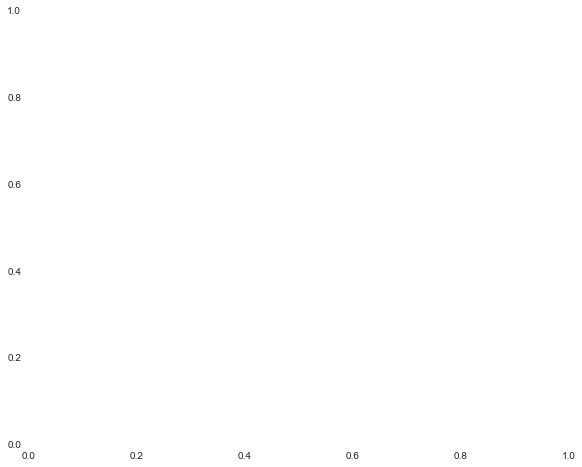

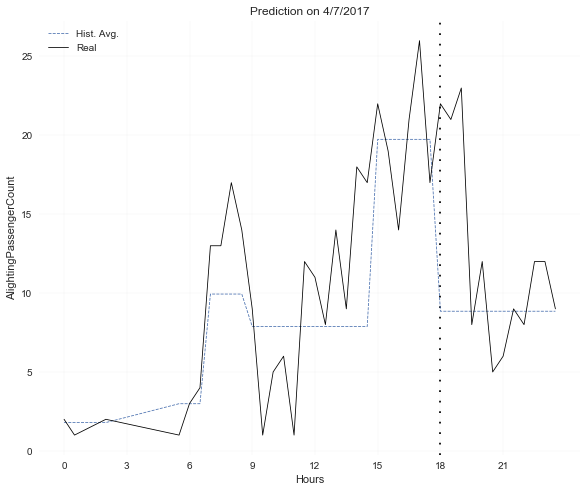

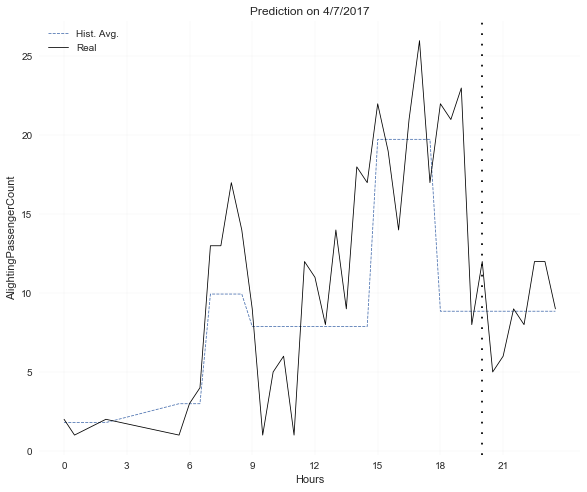

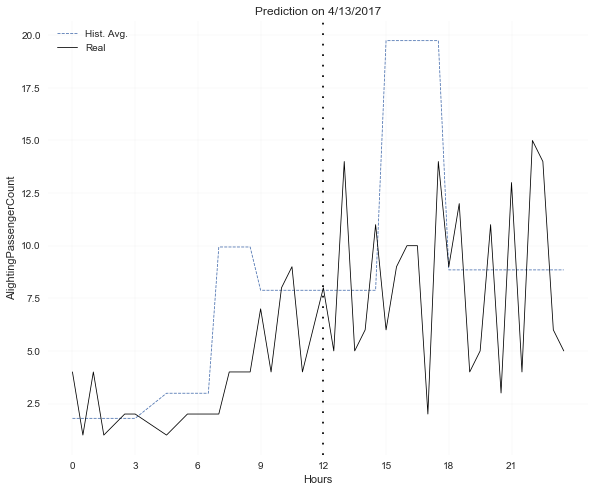

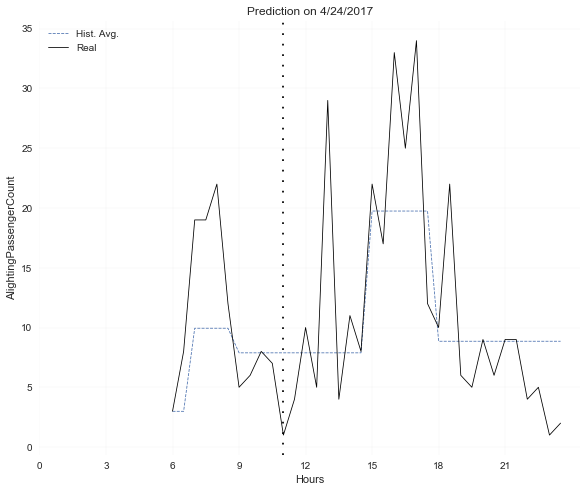

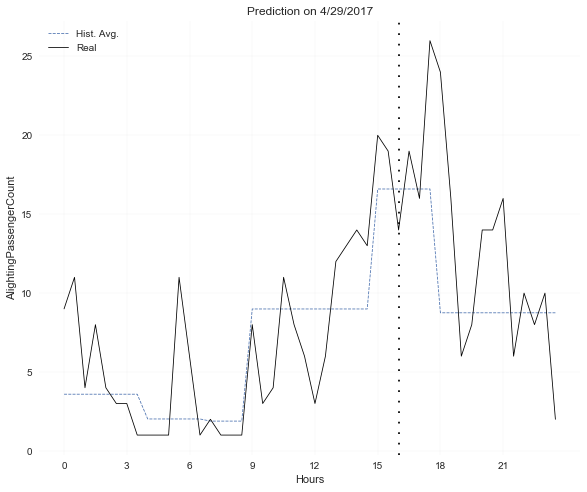

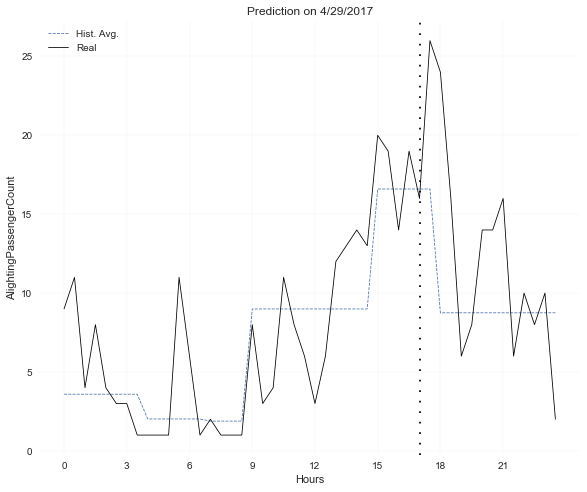

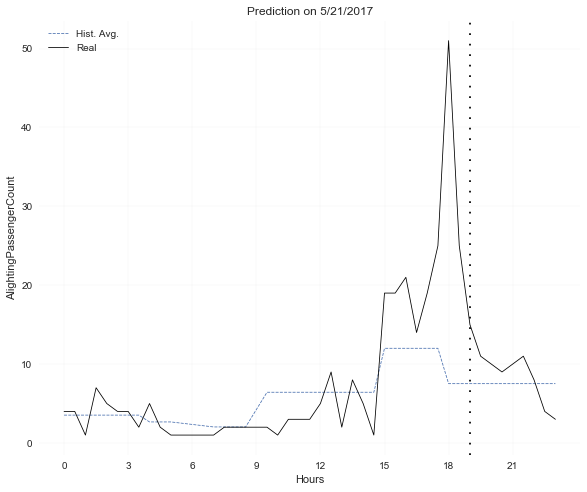

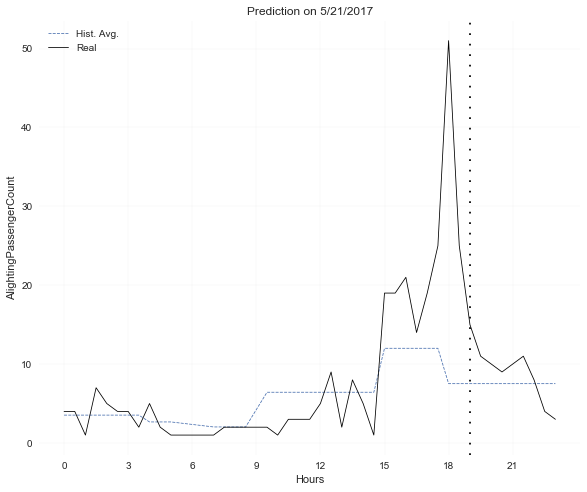

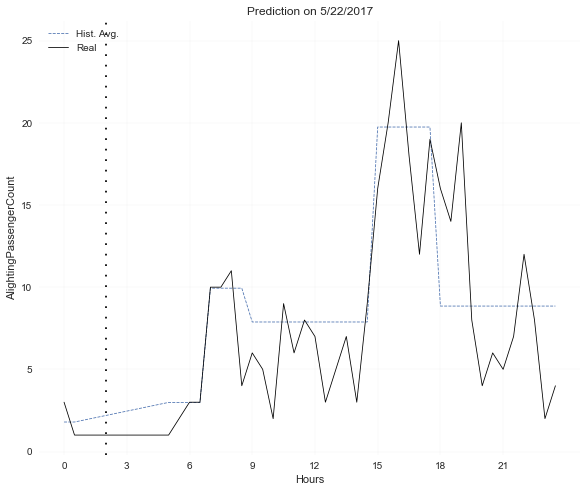

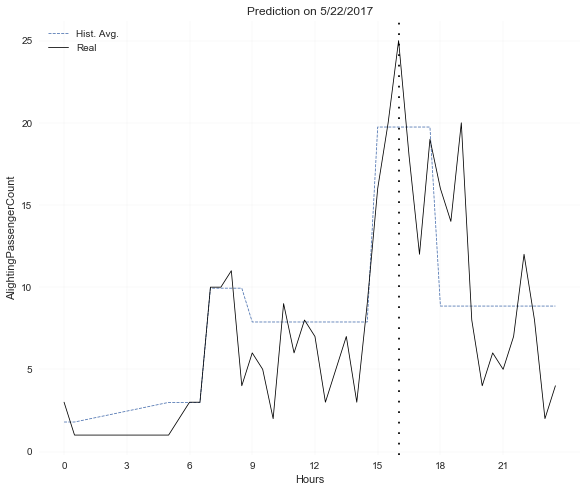

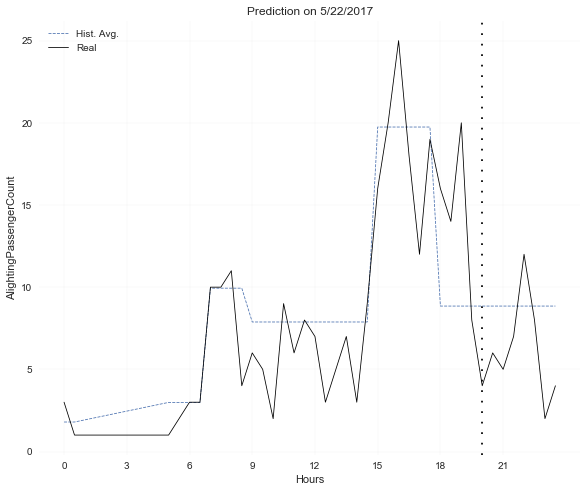

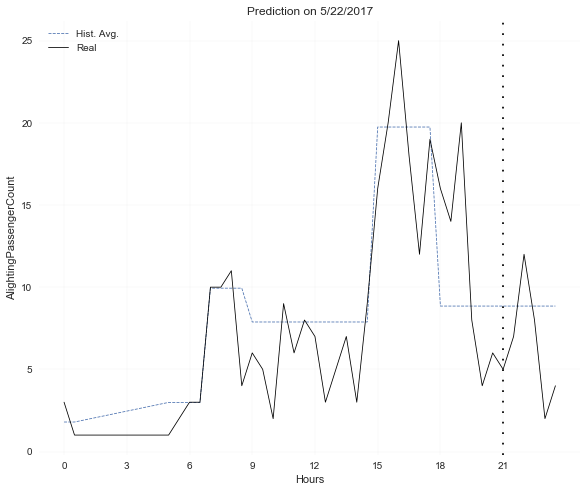

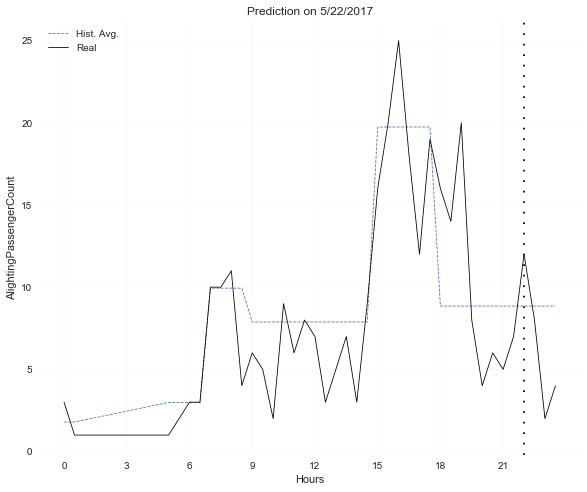

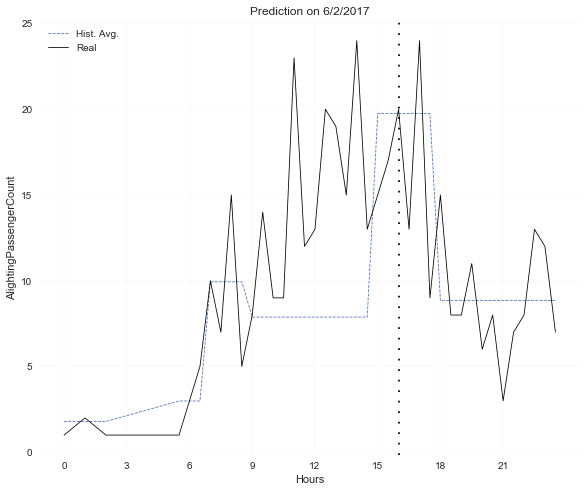

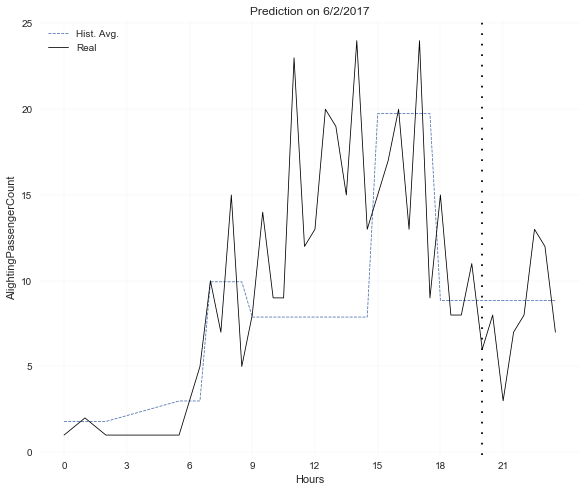

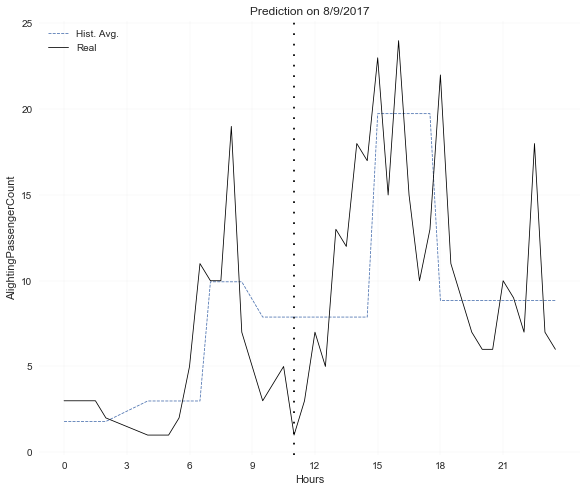

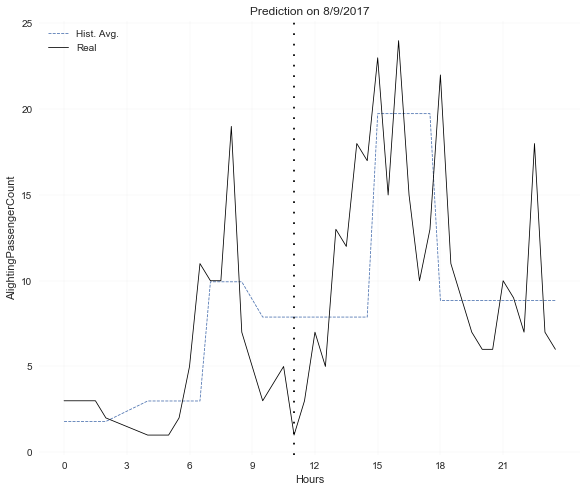

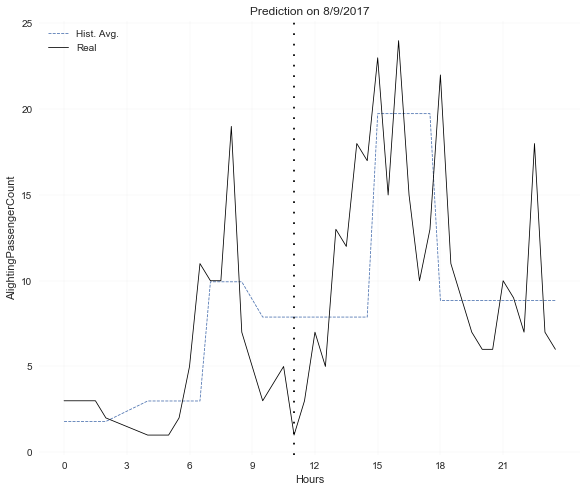

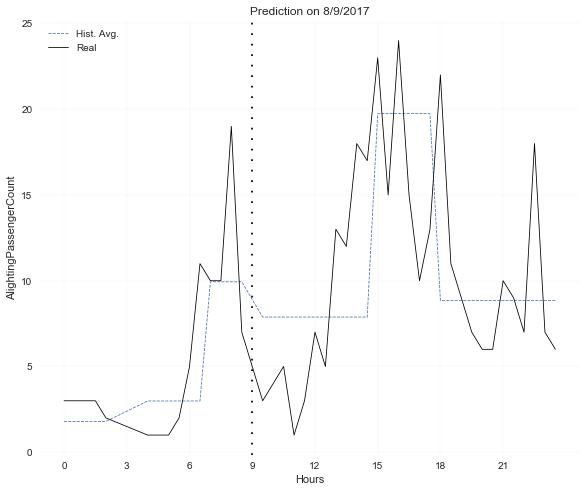

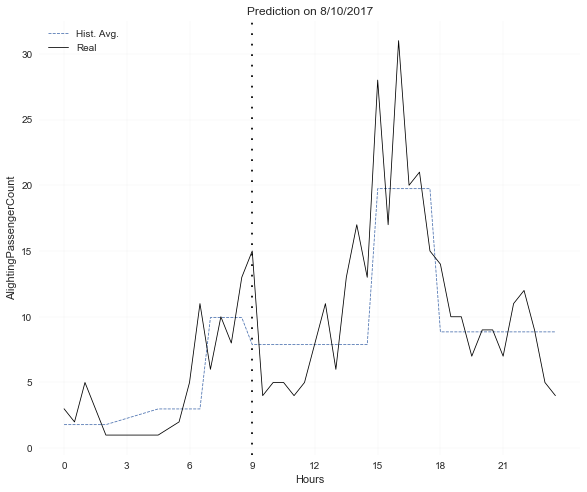

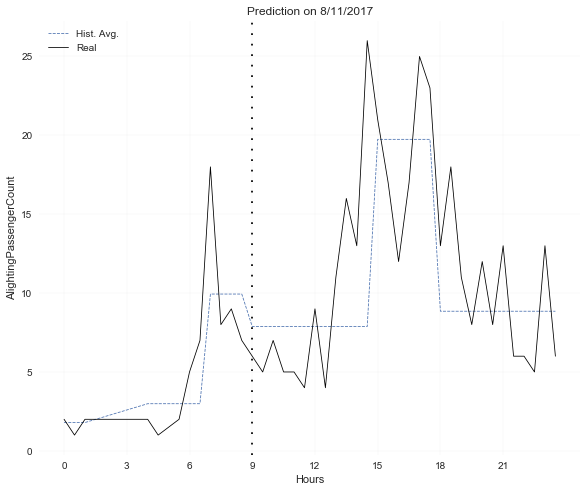

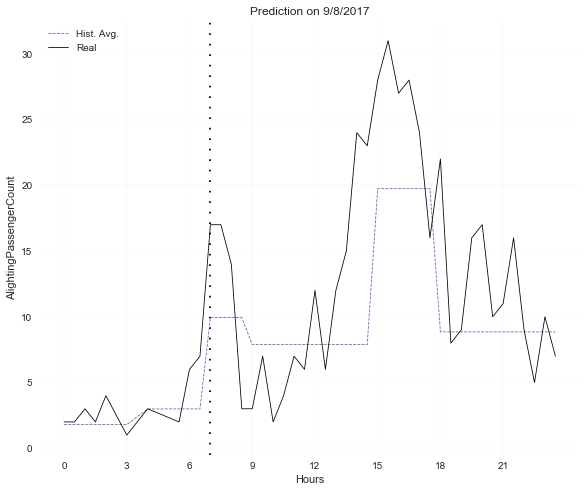

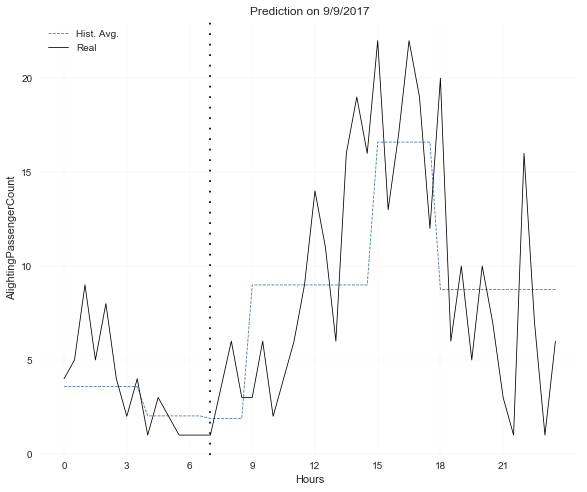

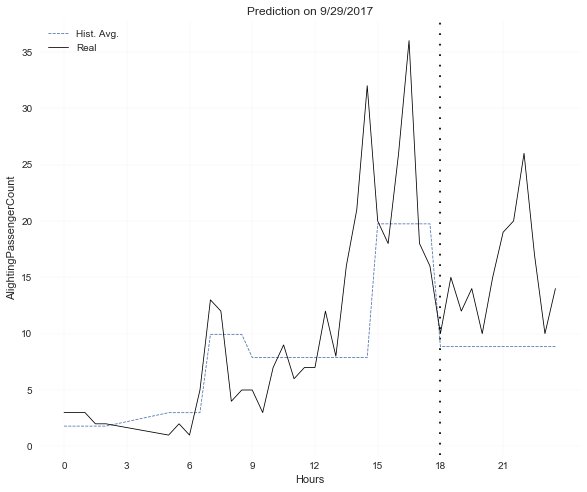

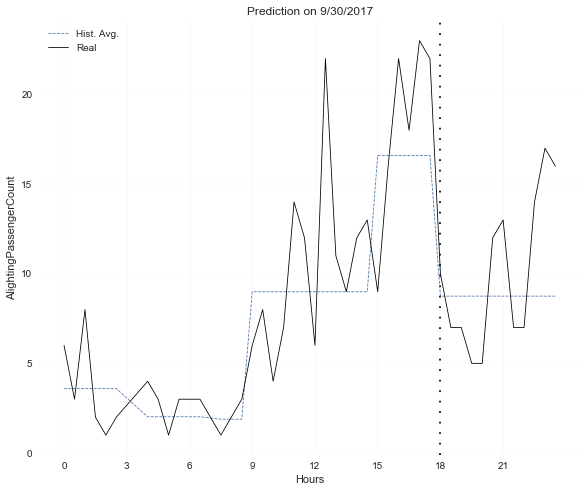

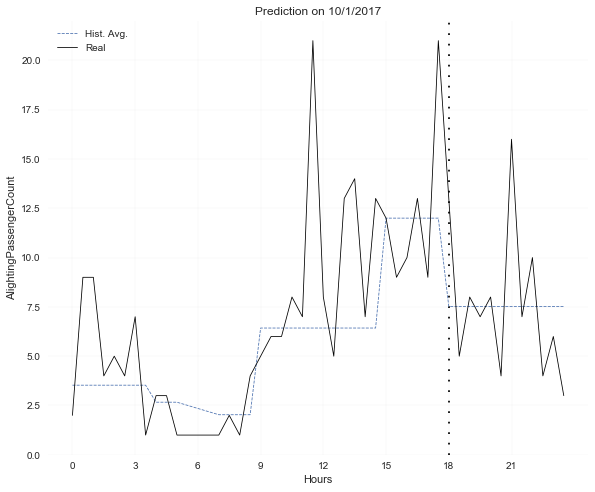

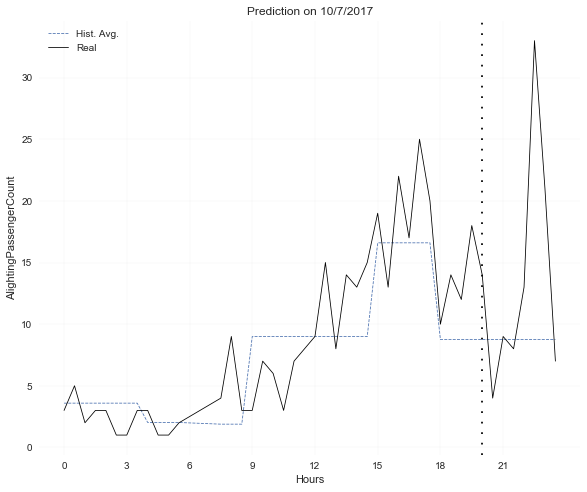

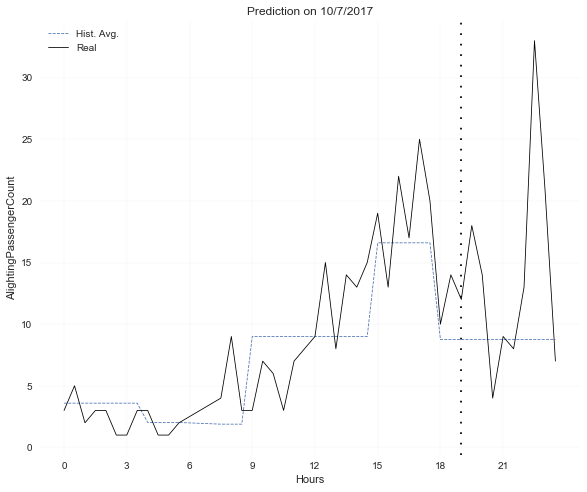

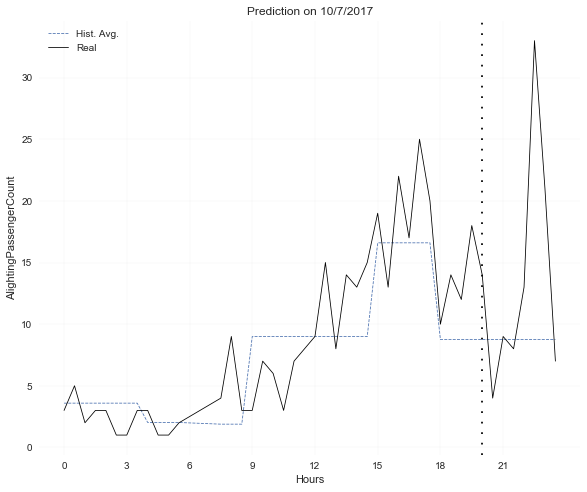

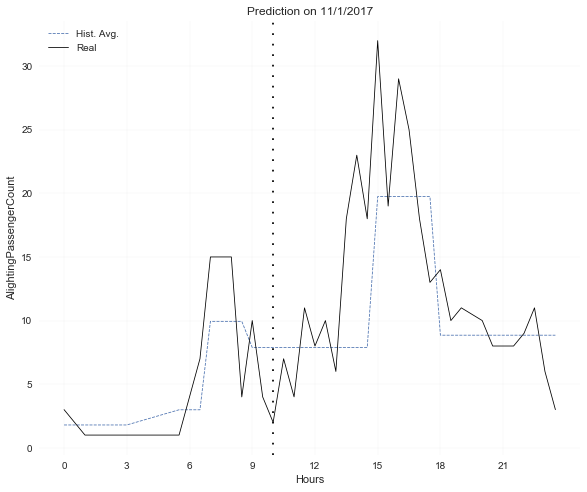

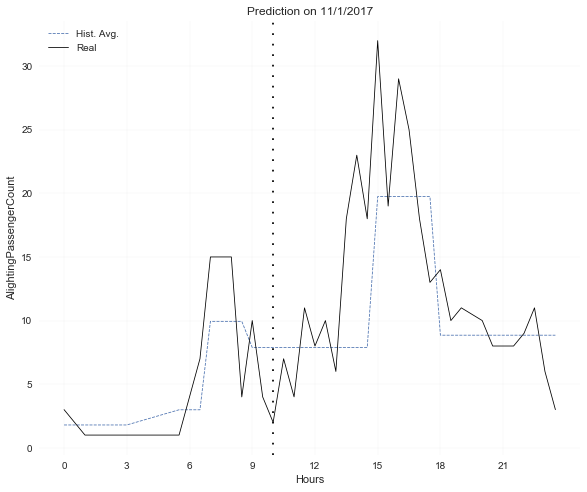

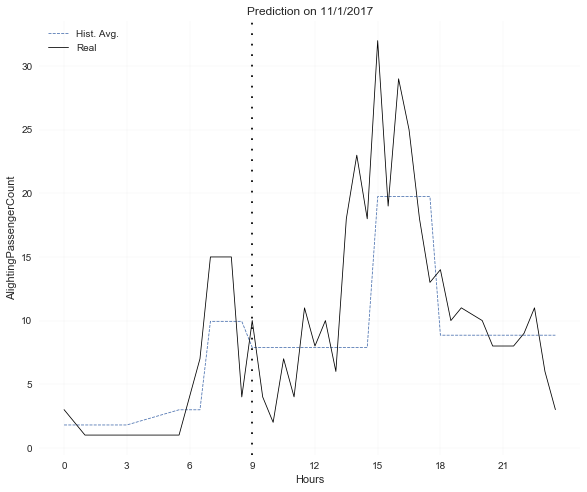

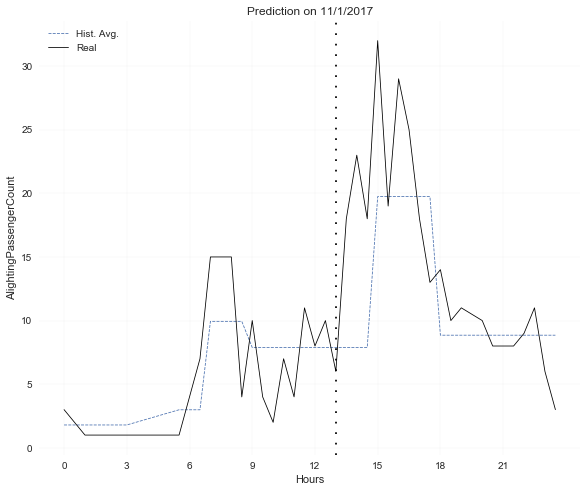

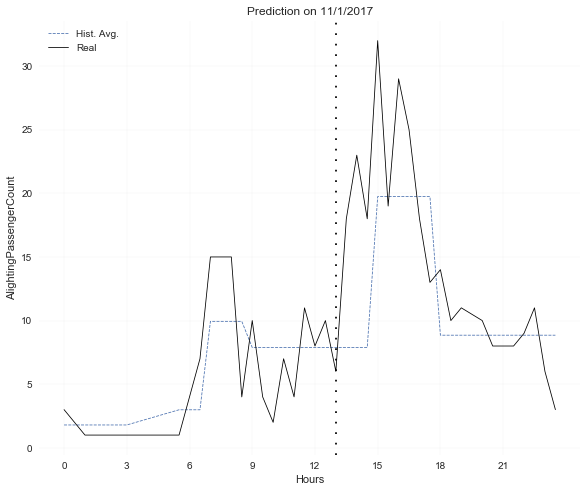

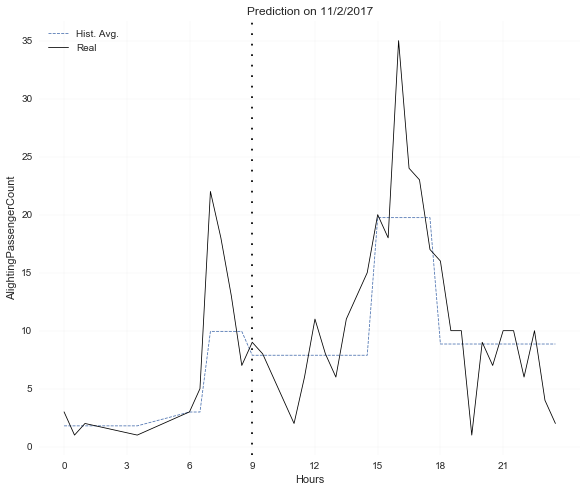

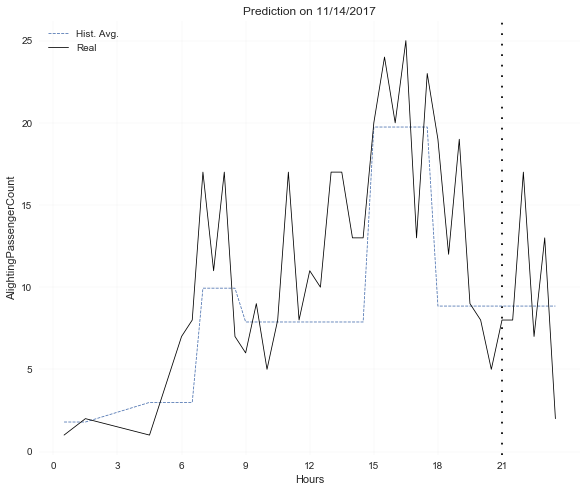

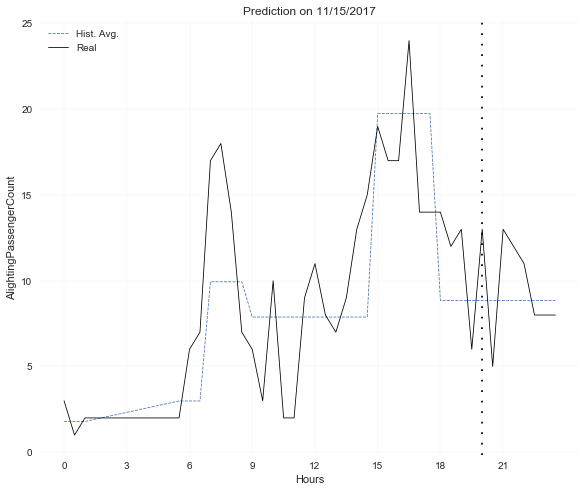

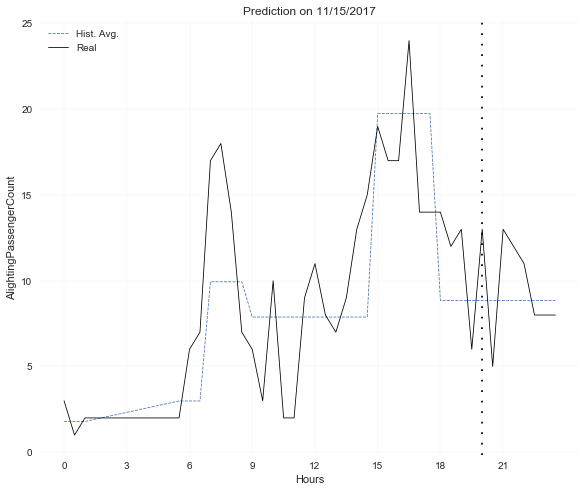

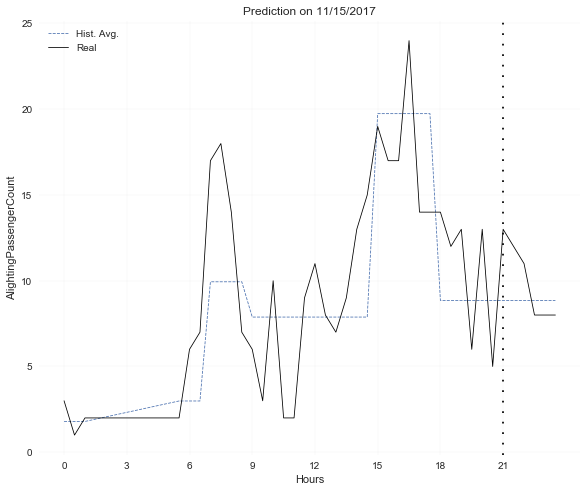

In [23]:
width = 700
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'


fig, ax1 = plt.subplots(1, 1, figsize=set_size(width))
    
    

ev=ev[ev['venue_unique']==test.PoiName.unique()[0]]
ev=ev[ev['starting_time'].dt.month>=test.TimeStep.dt.month[0]]
for date in ev.starting_time:
    da=date.day
    mo=date.month
    ho=date.hour

    test_inde=test.reset_index()
    indexs=test_inde.index[(test['TimeStep'].dt.month==mo) & (test['TimeStep'].dt.day==da)] 
    if len(indexs)>0:
        fig, ax1 = plt.subplots(1, 1, figsize=set_size(width))
        plt.axvline(ho,c="k",linestyle=(0, (1, 5)))
        H_min=test.iloc[indexs].hours+(test.iloc[indexs].TimeStep.dt.minute)/60
        
#         ax1.plot(H_min,y_hat[indexs],'--',color="C4",label="Bay. Regr.",linewidth=0.8)
#         ax1.plot(H_min,y_pred_lr[indexs],linestyle='-.',color="C1",label="L. Regr.",linewidth=0.8)
        ax1.plot(H_min,np.array(hist_average)[indexs],linestyle="--",color="C6",label="Hist. Avg.",linewidth=0.8)
        
        ax1.plot(H_min,y_test[0][indexs],c="k", label="Real",linewidth=0.8)
#         ax1.plot(H_min,y_pred_gp[indexs],linestyle=':',c="k",color="m",label="G.P.",linewidth=0.8)
        plt.rcParams['axes.facecolor']='white'
        plt.rcParams['savefig.facecolor']='white'
        plt.legend(loc=2)
        plt.xticks(range(0,24,3))
        plt.grid(b=True,c="grey",alpha=0.2,linewidth=0.2)
        plt.title("Prediction on %s/%s/2017"%(mo,da))
        plt.ylabel("%s"%(col_y[0]))
        plt.xlabel("Hours")

In [94]:
y_test,y_hat,y_pred_lr,hist_average,y_pred_gp,test,st,ev=make_prediction(al, 678, list_col_isEvent, col_y, col_x, "ADVI",ev,al_n)

Historical Average 	 1/4
Linear regression 	 2/4
0 minutes
Gaussian Process 	 3/4


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_faff050cb2fa152882f057ecae820ca9 NOW.


0 minutes
Bayesian inference 	 4/4


4 minutes


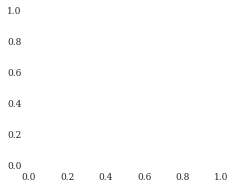

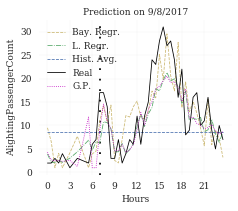

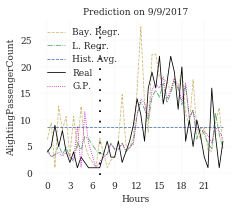

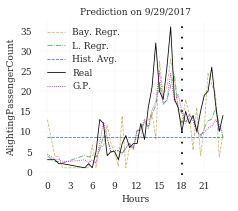

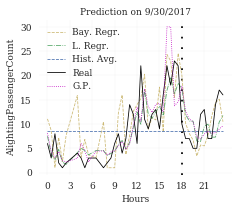

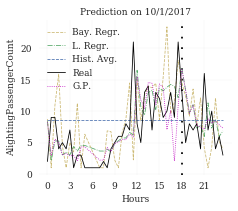

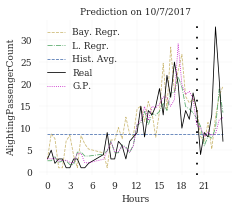

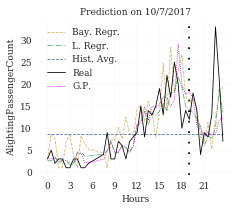

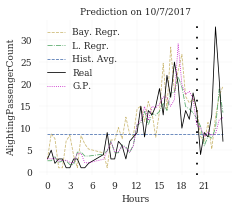

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\678_AlightingPassengerCount\\pdf_single_plot\\11_1.pdf'

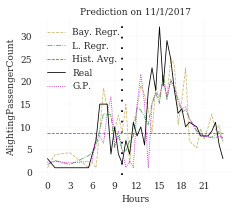

In [108]:
nice_fonts_small = {
        # Use LaTeX to write bol text
        "font.family": "serif",
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 9,
        "font.size": 9,
        # Make the legend/label fonts a little smboler
        "legend.fontsize": 6,
        "xtick.labelsize": 9,
        "ytick.labelsize": 9,
}



plt.rcParams.update(nice_fonts)


width = 250
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'


fig, ax1 = plt.subplots(1, 1, figsize=set_size(width))
    
    

ev=ev[ev['venue_unique']==test.PoiName.unique()[0]]
ev=ev[ev['starting_time'].dt.month>=test.TimeStep.dt.month[0]]
for date in ev.starting_time:
    da=date.day
    mo=date.month
    ho=date.hour

    test_inde=test.reset_index()
    indexs=test_inde.index[(test['TimeStep'].dt.month==mo) & (test['TimeStep'].dt.day==da)] 
    if len(indexs)>0:
        fig, ax1 = plt.subplots(1, 1, figsize=set_size(width))
        plt.axvline(ho,c="k",linestyle=(0, (1, 5)))
        H_min=test.iloc[indexs].hours+(test.iloc[indexs].TimeStep.dt.minute)/60
        
        ax1.plot(H_min,y_hat[indexs],'--',color="C4",label="Bay. Regr.",linewidth=0.8)
        ax1.plot(H_min,y_pred_lr[indexs],linestyle='-.',color="C1",label="L. Regr.",linewidth=0.8)
        ax1.plot(H_min,np.array(hist_average)[indexs],linestyle="--",color="C6",label="Hist. Avg.",linewidth=0.8)
        
        ax1.plot(H_min,y_test[0][indexs],c="k", label="Real",linewidth=0.8)
        ax1.plot(H_min,y_pred_gp[indexs],linestyle=':',c="k",color="m",label="G.P.",linewidth=0.8)
        plt.rcParams['axes.facecolor']='white'
        plt.rcParams['savefig.facecolor']='white'
        plt.legend(loc=2)
        plt.xticks(range(0,24,3))
        plt.grid(b=True,c="grey",alpha=0.2,linewidth=0.2)
        plt.title("Prediction on %s/%s/2017"%(mo,da))
        plt.ylabel("%s"%(col_y[0]))
        plt.xlabel("Hours")

        file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\pdf_single_plot\\"%(st,col_y[0])
        directory = os.path.dirname(file_path)
        if not os.path.exists(directory):
            os.makedirs(directory)
        file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\png_single_plot\\"%(st,col_y[0])
        directory = os.path.dirname(file_path)
        if not os.path.exists(directory):
            os.makedirs(directory)
        file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\svg_single_plot\\"%(st,col_y[0])
        directory = os.path.dirname(file_path)
        if not os.path.exists(directory):
            os.makedirs(directory)

        plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\pdf_single_plot\\%s_%s.pdf"%(st,col_y[0],mo,da), format='pdf', bbox_inches='tight')
        plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\png_single_plot\\%s_%s.png"%(st,col_y[0],mo,da), format='png', bbox_inches='tight')
        plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\svg_single_plot\\%s_%s.svg"%(st,col_y[0],mo,da), format='svg', bbox_inches='tight')
        plt.show()

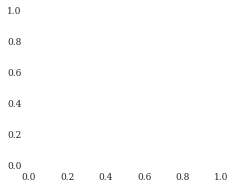

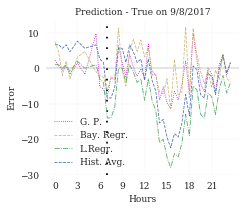

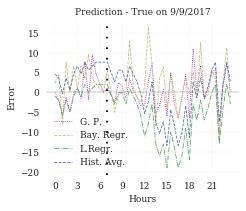

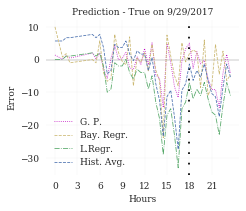

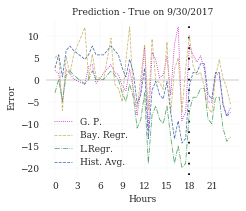

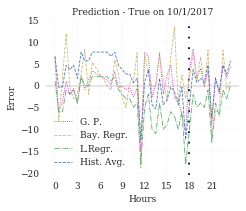

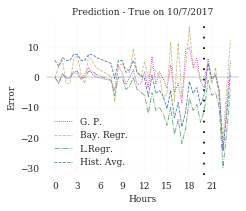

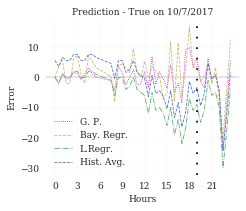

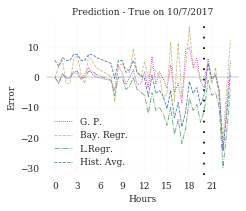

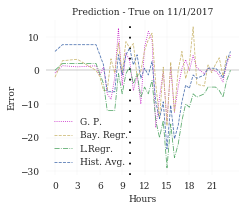

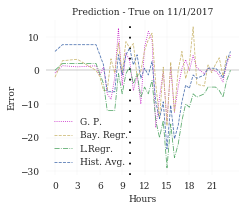

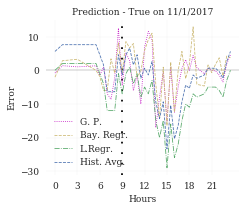

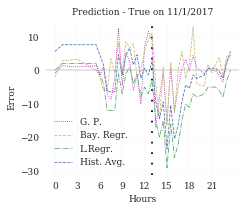

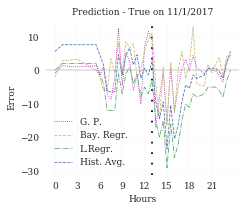

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\678_AlightingPassengerCount\\pdf_errors_plot\\11_2.pdf'

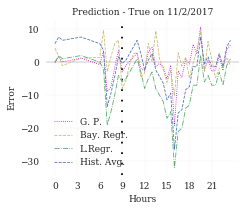

In [110]:
width = 250
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'


fig, ax1 = plt.subplots(1, 1, figsize=set_size(width))

ev=ev[ev['venue_unique']==test.PoiName.unique()[0]]
ev=ev[ev['starting_time'].dt.month>=test.TimeStep.dt.month[0]]

diffHA=hist_average-y_test
diffLR=y_pred_lr-y_test
diffGP=y_pred_gp-y_test
diffBA=y_hat-y_test



test_inde=test.reset_index()
index_test=test_inde.index[test_inde['isEvent']>0] 

Min=int(min(min(diffHA[0][index_test]),min(diffLR[0][index_test]),min(diffGP[0][index_test]),min(diffBA[0][index_test])))-5
Max=int(max(max(diffHA[0][index_test]),max(diffLR[0][index_test]),max(diffGP[0][index_test]),max(diffBA[0][index_test])))+5

for date in ev.starting_time:
    da=date.day
    mo=date.month
    ho=date.hour

    test_inde=test.reset_index()
    indexs=test_inde.index[(test['TimeStep'].dt.month==mo) & (test['TimeStep'].dt.day==da)] 
    if len(indexs)>0:
        fig, ax1 = plt.subplots(1, 1, figsize=set_size(width))
        plt.axhline(0,c="k",alpha=0.1)
        plt.axvline(ho,c="k",linestyle=(0, (1, 5)))
        H_min=test.iloc[indexs].hours+(test.iloc[indexs].TimeStep.dt.minute)/60  
#         ax1.plot(H_min,y_test[0,:][indexs],c="k",label="True",linewidth=0.8,alpha=0.2)
        ax1.plot(H_min,diffGP[0][indexs],linestyle=':',c="k",color="m",label="G. P.",linewidth=0.8)
        ax1.plot(H_min,diffBA[0][indexs],'--',color="C4",label="Bay. Regr.",linewidth=0.8)
        ax1.plot(H_min,diffLR[0][indexs],linestyle='-.',color="C1",label="L.Regr.",linewidth=0.8)
        ax1.plot(H_min,diffHA[0][indexs],linestyle="--",color="C6",label="Hist. Avg.",linewidth=0.8)
        plt.rcParams['axes.facecolor']='white'
        plt.rcParams['savefig.facecolor']='white'
        plt.legend()
        plt.xticks(range(0,24,3))
#         plt.ylim([-40,40])
        plt.grid(b=True,c="grey",alpha=0.2,linewidth=0.2)
        plt.title("Prediction - True on %s/%s/2017"%(mo,da))
        plt.ylabel("Error")
        plt.xlabel("Hours")

        file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\pdf_errors_plot\\"%(st,col_y[0])
        directory = os.path.dirname(file_path)
        if not os.path.exists(directory):
            os.makedirs(directory)
        file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\png_errors_plot\\"%(st,col_y[0])
        directory = os.path.dirname(file_path)
        if not os.path.exists(directory):
            os.makedirs(directory)
        file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\svg_errors_plot\\"%(st,col_y[0])
        directory = os.path.dirname(file_path)
        if not os.path.exists(directory):
            os.makedirs(directory)

        plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\pdf_errors_plot\\%s_%s.pdf"%(st,col_y[0],mo,da), format='pdf', bbox_inches='tight')
        plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\png_errors_plot\\%s_%s.png"%(st,col_y[0],mo,da), format='png', bbox_inches='tight')
        plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\svg_errors_plot\\%s_%s.svg"%(st,col_y[0],mo,da), format='svg', bbox_inches='tight')
        plt.show()


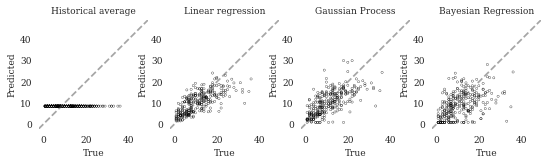

In [82]:

plt.rcParams['figure.figsize'] = (9, 2)
plt.rcParams.update(nice_fonts)

test_inde=test.reset_index()
index_test=test_inde.index[test_inde['isEvent']>0] 

width = 500
# plt.rcParams['axes.facecolor']='white'
# plt.rcParams['savefig.facecolor']='white'

HA=np.array(hist_average)
models=[HA[index_test],y_pred_lr[:,0][index_test],y_pred_gp[index_test],y_hat[index_test]]
labels=["---","Historical Average","Linear Regression", "Gaussian Process","Bayesian Inference"]
i =0
# for mo in models:

plt.subplot2grid((1,4),(0,0))

plt.scatter(y_test[0][index_test],HA[index_test],s=5, facecolors='none', edgecolors='k')
yLim=max(y_test[0])
plt.ylim(-2,yLim+2)
plt.xlim(-2,yLim+2)
plt.plot([-2,yLim+2], [-2,yLim+2], ls="--", c=".3",alpha=0.5)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("Historical average")

    
    
plt.subplot2grid((1,4),(0,1))
plt.scatter(y_test[0][index_test],y_pred_lr[:,0][index_test],s=5, facecolors='none', edgecolors='k')
yLim=max(y_test[0])
plt.ylim(-2,yLim+2)
plt.xlim(-2,yLim+2)
plt.plot([-2,yLim+2], [-2,yLim+2], ls="--", c=".3",alpha=0.5)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("Linear regression")

    
    
    
plt.subplot2grid((1,4),(0,2))
plt.scatter(y_test[0][index_test],y_pred_gp[index_test],s=5, facecolors='none', edgecolors='k')
yLim=max(y_test[0])
plt.ylim(-2,yLim+2)
plt.xlim(-2,yLim+2)
plt.plot([-2,yLim+2], [-2,yLim+2], ls="--", c=".3",alpha=0.5)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("Gaussian Process")



plt.subplot2grid((1,4),(0,3))
plt.scatter(y_test[0][index_test],y_hat[index_test],s=5, facecolors='none', edgecolors='k')
yLim=max(y_test[0])
plt.ylim(-2,yLim+2)
plt.xlim(-2,yLim+2)
plt.plot([-2,yLim+2], [-2,yLim+2], ls="--", c=".3",alpha=0.5)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("Bayesian Regression")

    
    
    

    
    
    
    
    

#     file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\pdf_45Degree\\"%(st,col_y[0])
#     directory = os.path.dirname(file_path)
#     if not os.path.exists(directory):
#         os.makedirs(directory)
#     file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\png_45Degree\\"%(st,col_y[0])
#     directory = os.path.dirname(file_path)
#     if not os.path.exists(directory):
#         os.makedirs(directory)
#     file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\svg_45Degree\\"%(st,col_y[0])
#     directory = os.path.dirname(file_path)
#     if not os.path.exists(directory):
#         os.makedirs(directory)

plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\pdf_45Degree\\%s_%s_%s.pdf"%(st,col_y[0],labels[i],st,col_y[0]), format='pdf', bbox_inches='tight')
# plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\png_45Degree\\%s_%s.png"%(st,col_y[0],st,col_y[0]), format='png', bbox_inches='tight')
# plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\svg_45Degree\\%s_%s.svg"%(st,col_y[0],st,col_y[0]), format='svg', bbox_inches='tight')
plt.show()

# Boarding

In [9]:
col_y=['BoardingPassengerCount']

col_x=[
    'BoardingPassengerCount_lag1', #'BoardingPassengerCount_lag2', 'BoardingPassengerCount_lag3','BoardingPassengerCount_lag4', 'BoardingPassengerCount_lag5',
#     'BoardingPassengerCount_lag38','BoardingPassengerCount_lag39','BoardingPassengerCount_lag40','BoardingPassengerCount_lag41','BoardingPassengerCount_lag42',
#     'BoardingPassengerCount_lag80','BoardingPassengerCount_lag81','BoardingPassengerCount_lag82','BoardingPassengerCount_lag83',
#     'BoardingPassengerCount_lag123','BoardingPassengerCount_lag124','BoardingPassengerCount_lag125',
#     'BoardingPassengerCount_lag165','BoardingPassengerCount_lag166',
    
#     'Alternative&Punk_Music', 'Business', 'Children', 'Classic_Music','Culture', 'Design', 'Education',
#     'Electronica_Music', 'Entertainment', 
#     'Football', 'Outdoor_Festival','Music',
#     'Indipendent_Music', 'Lifestyle', 'Medicine', 'Metal_Music', 
    
#     'Pop_Music', 'Religious_Music', 'Rock_Music','Sport', 'StageMusicals_Music','Traditional_Music', 'Urban_Music',
    
#     'isWeekend',
    'H0_4', 'H4_8', 'H8_12', 'H12_16', 'H16_20', 'H20_24',
    
#     'Precipitation',
#     'Temperature',
       ]



list_col_isEvent=[ 
'event_1h_aft', 'event_2h_aft', 'event_3h_aft',  'event_during_6h_aft',#'event_during_4h_aft','event_during_5h_aft',
]

In [10]:
# list_col_isEvent=['event_during_2h_aft', 'event_during_3h_aft','event_during_4h_aft', 'event_during_5h_aft']
y_test,y_hat,y_pred_lr,hist_average,y_pred_gp,test,st,ev=make_prediction(bo, 678, list_col_isEvent, col_y, col_x, "ADVI",ev,bo_n)

Historical Average 	 1/4
Linear regression 	 2/4
0 minutes
Gaussian Process 	 3/4


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_faff050cb2fa152882f057ecae820ca9 NOW.


0 minutes
Bayesian inference 	 4/4


2 minutes


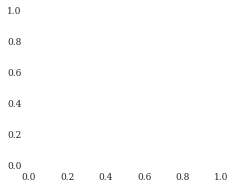

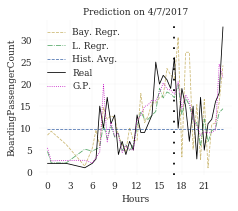

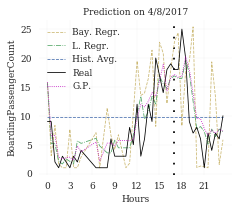

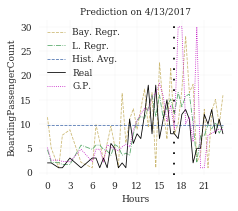

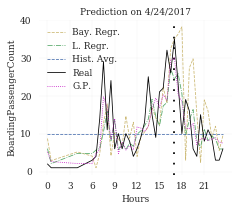

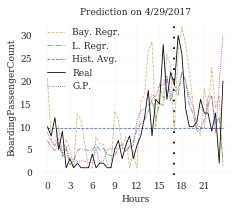

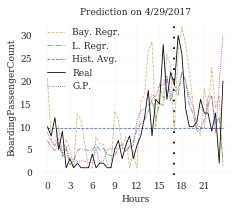

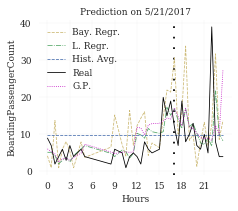

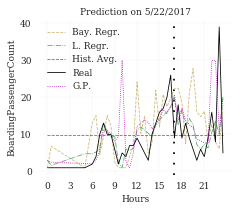

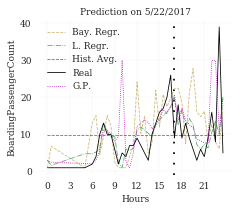

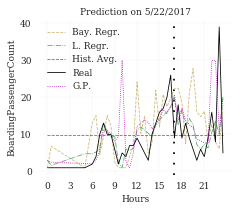

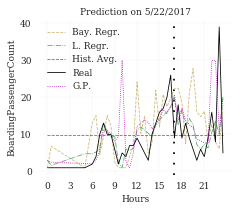

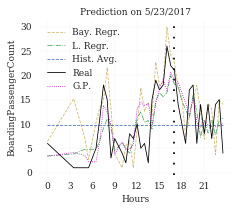

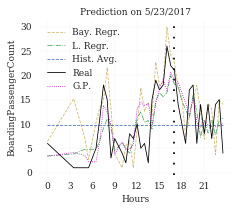

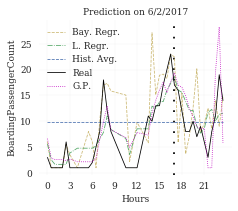

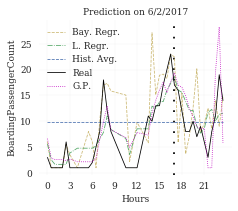

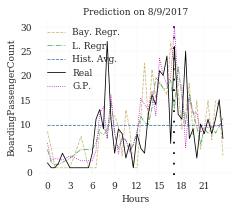

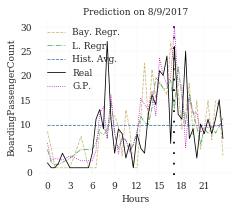

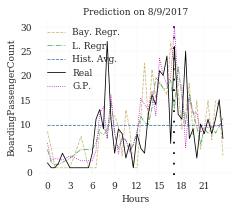

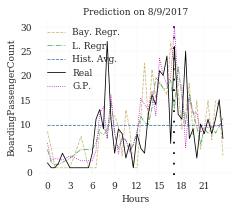

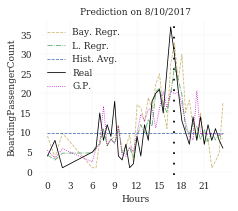

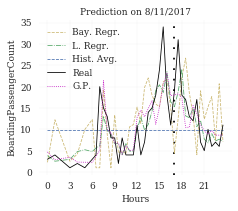

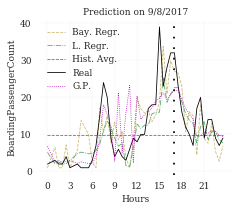

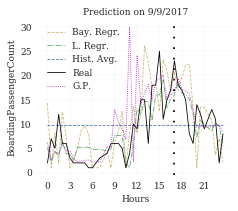

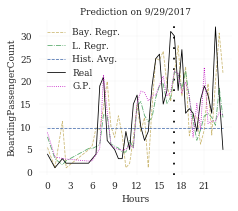

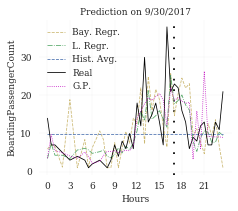

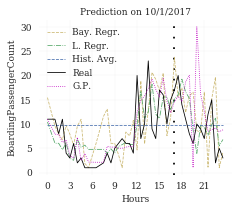

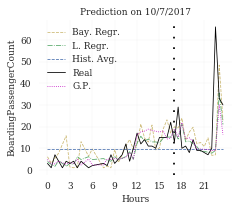

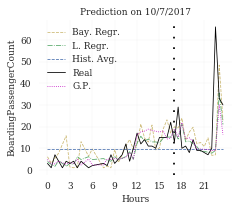

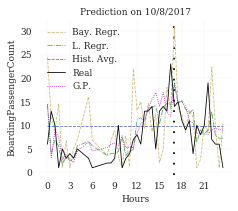

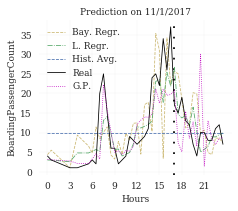

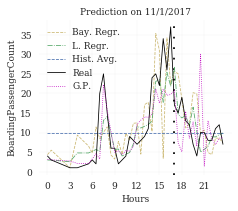

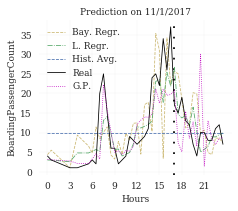

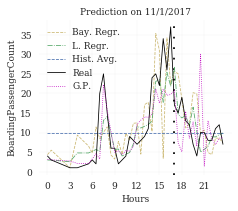

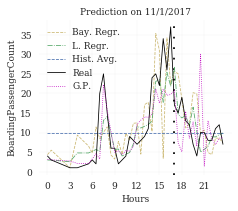

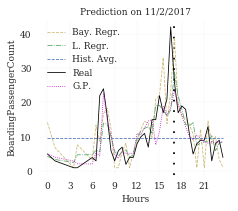

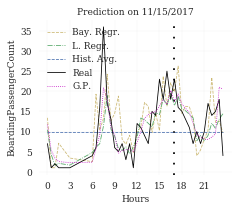

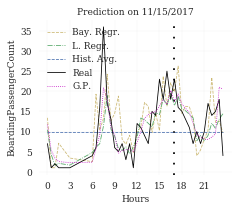

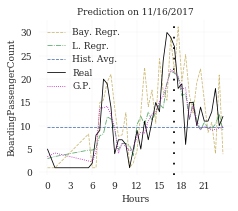

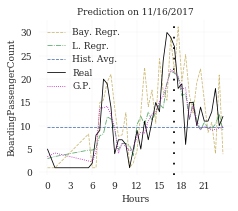

In [11]:
nice_fonts_small = {
        # Use LaTeX to write bol text
        "font.family": "serif",
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 9,
        "font.size": 9,
        # Make the legend/label fonts a little smboler
        "legend.fontsize": 6,
        "xtick.labelsize": 9,
        "ytick.labelsize": 9,
}



plt.rcParams.update(nice_fonts)


width = 250
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'


fig, ax1 = plt.subplots(1, 1, figsize=set_size(width))


ev=ev[ev['venue_unique']==test.PoiName.unique()[0]]
ev=ev[ev['starting_time'].dt.month>=test.TimeStep.dt.month[0]]
for date in ev.end_time:
    da=date.day
    mo=date.month
    ho=date.hour

    test_inde=test.reset_index()
    indexs=test_inde.index[(test['TimeStep'].dt.month==mo) & (test['TimeStep'].dt.day==da)] 
    if len(indexs)>0:
        fig, ax1 = plt.subplots(1, 1, figsize=set_size(width))
        plt.axvline(17,c="k",linestyle=(0, (1, 5)))
        H_min=test.iloc[indexs].hours+(test.iloc[indexs].TimeStep.dt.minute)/60
        
        ax1.plot(H_min,y_hat[indexs],'--',color="C4",label="Bay. Regr.",linewidth=0.8)
        ax1.plot(H_min,y_pred_lr[indexs],linestyle='-.',color="C1",label="L. Regr.",linewidth=0.8)
        ax1.plot(H_min,np.array(hist_average)[indexs],linestyle="--",color="C6",label="Hist. Avg.",linewidth=0.8)
        
        ax1.plot(H_min,y_test[0][indexs],c="k", label="Real",linewidth=0.8)
        ax1.plot(H_min,y_pred_gp[indexs],linestyle=':',c="k",color="m",label="G.P.",linewidth=0.8)
        plt.rcParams['axes.facecolor']='white'
        plt.rcParams['savefig.facecolor']='white'
        plt.legend(loc=2)
        plt.xticks(range(0,24,3))
        plt.grid(b=True,c="grey",alpha=0.2,linewidth=0.2)
        plt.title("Prediction on %s/%s/2017"%(mo,da))
        plt.ylabel("%s"%(col_y[0]))
        plt.xlabel("Hours")

        file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\pdf_single_plot\\"%(st,col_y[0])
        directory = os.path.dirname(file_path)
        if not os.path.exists(directory):
            os.makedirs(directory)
        file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\png_single_plot\\"%(st,col_y[0])
        directory = os.path.dirname(file_path)
        if not os.path.exists(directory):
            os.makedirs(directory)
        file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\svg_single_plot\\"%(st,col_y[0])
        directory = os.path.dirname(file_path)
        if not os.path.exists(directory):
            os.makedirs(directory)

        plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\pdf_single_plot\\%s_%s.pdf"%(st,col_y[0],mo,da), format='pdf', bbox_inches='tight')
        plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\png_single_plot\\%s_%s.png"%(st,col_y[0],mo,da), format='png', bbox_inches='tight')
        plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\svg_single_plot\\%s_%s.svg"%(st,col_y[0],mo,da), format='svg', bbox_inches='tight')
        plt.show()

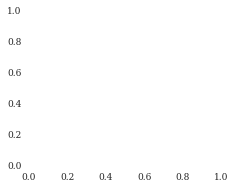

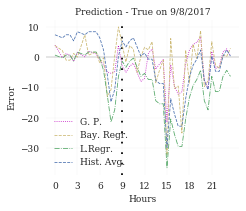

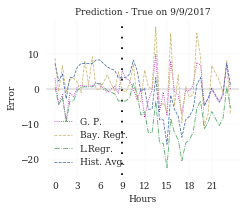

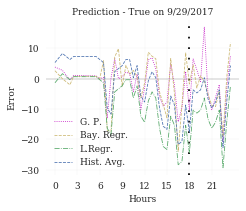

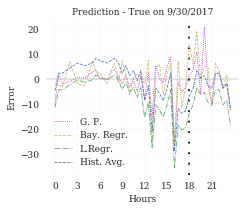

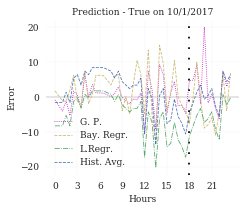

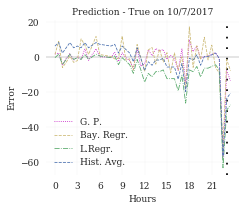

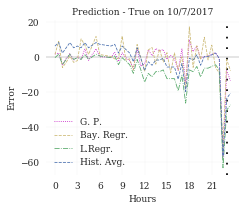

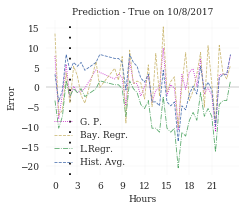

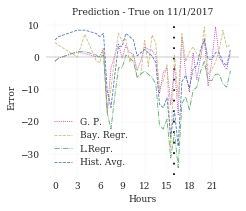

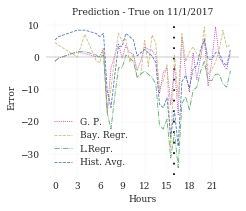

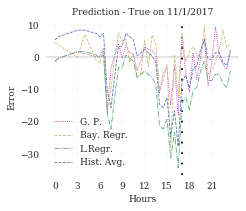

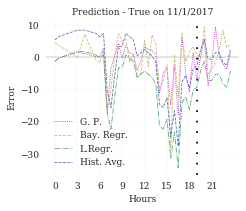

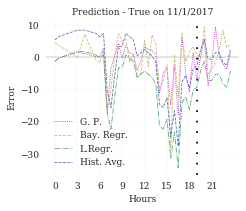

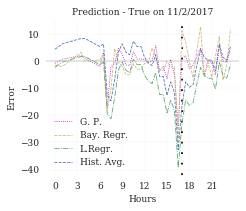

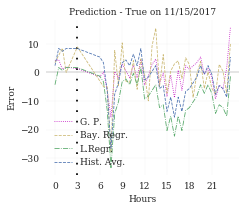

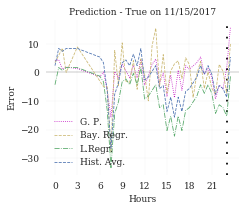

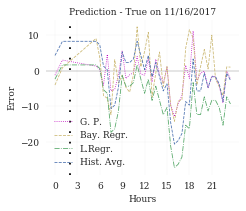

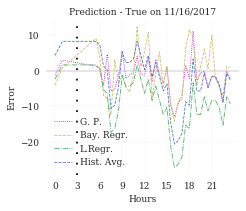

In [158]:
width = 250
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'


fig, ax1 = plt.subplots(1, 1, figsize=set_size(width))

ev=ev[ev['venue_unique']==test.PoiName.unique()[0]]
ev=ev[ev['starting_time'].dt.month>=test.TimeStep.dt.month[0]]

diffHA=hist_average-y_test
diffLR=y_pred_lr-y_test
diffGP=y_pred_gp-y_test
diffBA=y_hat-y_test



test_inde=test.reset_index()
index_test=test_inde.index[test_inde['isEvent']>0] 

Min=int(min(min(diffHA[0][index_test]),min(diffLR[0][index_test]),min(diffGP[0][index_test]),min(diffBA[0][index_test])))-5
Max=int(max(max(diffHA[0][index_test]),max(diffLR[0][index_test]),max(diffGP[0][index_test]),max(diffBA[0][index_test])))+5

for date in ev.end_time:
    da=date.day
    mo=date.month
    ho=date.hour

    test_inde=test.reset_index()
    indexs=test_inde.index[(test['TimeStep'].dt.month==mo) & (test['TimeStep'].dt.day==da)] 
    if len(indexs)>0:
        fig, ax1 = plt.subplots(1, 1, figsize=set_size(width))
        plt.axhline(0,c="k",alpha=0.1)
        plt.axvline(ho,c="k",linestyle=(0, (1, 5)))
        H_min=test.iloc[indexs].hours+(test.iloc[indexs].TimeStep.dt.minute)/60  
#         ax1.plot(H_min,y_test[0,:][indexs],c="k",label="True",linewidth=0.8,alpha=0.2)
        ax1.plot(H_min,diffGP[0][indexs],linestyle=':',c="k",color="m",label="G. P.",linewidth=0.8)
        ax1.plot(H_min,diffBA[0][indexs],'--',color="C4",label="Bay. Regr.",linewidth=0.8)
        ax1.plot(H_min,diffLR[0][indexs],linestyle='-.',color="C1",label="L.Regr.",linewidth=0.8)
        ax1.plot(H_min,diffHA[0][indexs],linestyle="--",color="C6",label="Hist. Avg.",linewidth=0.8)
        plt.rcParams['axes.facecolor']='white'
        plt.rcParams['savefig.facecolor']='white'
        plt.legend()
        plt.xticks(range(0,24,3))
#         plt.ylim([-40,40])
        plt.grid(b=True,c="grey",alpha=0.2,linewidth=0.2)
        plt.title("Prediction - True on %s/%s/2017"%(mo,da))
        plt.ylabel("Error")
        plt.xlabel("Hours")

        file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\pdf_errors_plot\\"%(st,col_y[0])
        directory = os.path.dirname(file_path)
        if not os.path.exists(directory):
            os.makedirs(directory)
        file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\png_errors_plot\\"%(st,col_y[0])
        directory = os.path.dirname(file_path)
        if not os.path.exists(directory):
            os.makedirs(directory)
        file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\svg_errors_plot\\"%(st,col_y[0])
        directory = os.path.dirname(file_path)
        if not os.path.exists(directory):
            os.makedirs(directory)

        plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\pdf_errors_plot\\%s_%s.pdf"%(st,col_y[0],mo,da), format='pdf', bbox_inches='tight')
        plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\png_errors_plot\\%s_%s.png"%(st,col_y[0],mo,da), format='png', bbox_inches='tight')
        plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\svg_errors_plot\\%s_%s.svg"%(st,col_y[0],mo,da), format='svg', bbox_inches='tight')
        plt.show()


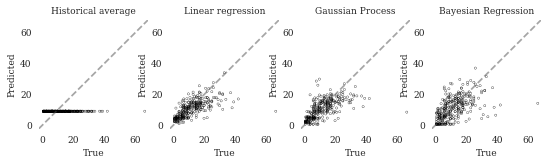

In [159]:

plt.rcParams['figure.figsize'] = (9, 2)
plt.rcParams.update(nice_fonts)

test_inde=test.reset_index()
index_test=test_inde.index[test_inde['isEvent']>0] 

width = 500
# plt.rcParams['axes.facecolor']='white'
# plt.rcParams['savefig.facecolor']='white'

HA=np.array(hist_average)
models=[HA[index_test],y_pred_lr[:,0][index_test],y_pred_gp[index_test],y_hat[index_test]]
labels=["---","Historical Average","Linear Regression", "Gaussian Process","Bayesian Inference"]
i =0
# for mo in models:

plt.subplot2grid((1,4),(0,0))

plt.scatter(y_test[0][index_test],HA[index_test],s=5, facecolors='none', edgecolors='k')
yLim=max(y_test[0])
plt.ylim(-2,yLim+2)
plt.xlim(-2,yLim+2)
plt.plot([-2,yLim+2], [-2,yLim+2], ls="--", c=".3",alpha=0.5)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("Historical average")

    
    
plt.subplot2grid((1,4),(0,1))
plt.scatter(y_test[0][index_test],y_pred_lr[:,0][index_test],s=5, facecolors='none', edgecolors='k')
yLim=max(y_test[0])
plt.ylim(-2,yLim+2)
plt.xlim(-2,yLim+2)
plt.plot([-2,yLim+2], [-2,yLim+2], ls="--", c=".3",alpha=0.5)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("Linear regression")

    
    
    
plt.subplot2grid((1,4),(0,2))
plt.scatter(y_test[0][index_test],y_pred_gp[index_test],s=5, facecolors='none', edgecolors='k')
yLim=max(y_test[0])
plt.ylim(-2,yLim+2)
plt.xlim(-2,yLim+2)
plt.plot([-2,yLim+2], [-2,yLim+2], ls="--", c=".3",alpha=0.5)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("Gaussian Process")



plt.subplot2grid((1,4),(0,3))
plt.scatter(y_test[0][index_test],y_hat[index_test],s=5, facecolors='none', edgecolors='k')
yLim=max(y_test[0])
plt.ylim(-2,yLim+2)
plt.xlim(-2,yLim+2)
plt.plot([-2,yLim+2], [-2,yLim+2], ls="--", c=".3",alpha=0.5)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("Bayesian Regression")

    
    
    

    
    
    
    
    

#     file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\pdf_45Degree\\"%(st,col_y[0])
#     directory = os.path.dirname(file_path)
#     if not os.path.exists(directory):
#         os.makedirs(directory)
#     file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\png_45Degree\\"%(st,col_y[0])
#     directory = os.path.dirname(file_path)
#     if not os.path.exists(directory):
#         os.makedirs(directory)
#     file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\svg_45Degree\\"%(st,col_y[0])
#     directory = os.path.dirname(file_path)
#     if not os.path.exists(directory):
#         os.makedirs(directory)

plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\pdf_45Degree\\%s_%s_%s.pdf"%(st,col_y[0],labels[i],st,col_y[0]), format='pdf', bbox_inches='tight')
# plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\png_45Degree\\%s_%s.png"%(st,col_y[0],st,col_y[0]), format='png', bbox_inches='tight')
# plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\svg_45Degree\\%s_%s.svg"%(st,col_y[0],st,col_y[0]), format='svg', bbox_inches='tight')
plt.show()

In [ ]:
# list_col_isEvent=['event_during_4h_aft', 'event_during_5h_aft','event_during_6h_aft']
make_prediction(bo, 28000, list_col_isEvent, col_y, col_x,  "ADVI",ev)

In [ ]:
make_prediction(bo, 28005, list_col_isEvent, col_y, col_x,  "ADVI",ev)

In [ ]:
make_prediction(bo, 1365, list_col_isEvent, col_y, col_x,  "ADVI",ev)

In [ ]:
make_prediction(bo, 27548, list_col_isEvent, col_y, col_x,  "ADVI",ev)

In [ ]:
make_prediction(bo, 1586, list_col_isEvent, col_y, col_x,  "ADVI",ev)

In [ ]:
make_prediction(bo, 27999, list_col_isEvent, col_y, col_x,  "ADVI",ev)

In [ ]:
make_prediction(bo, 860, list_col_isEvent, col_y, col_x,  "ADVI",ev)

In [ ]:
make_prediction(bo, 715, list_col_isEvent, col_y, col_x,  "ADVI",ev)

In [ ]:
make_prediction(bo, 30942, list_col_isEvent, col_y, col_x,  "ADVI",ev)

In [ ]:
make_prediction(bo, 7081, list_col_isEvent, col_y, col_x,  "ADVI",ev)

In [ ]:
make_prediction(bo, 1409, list_col_isEvent, col_y, col_x,  "ADVI",ev)

In [ ]:
make_prediction(bo, 46743, list_col_isEvent, col_y, col_x,  "ADVI",ev)

---------

# Dwell time

In [15]:
def plotting_error_dw(y_test, y_hat, y_pred_lr, hist_average, y_pred_gp,test,st,ev):
    plt.rcParams['figure.figsize'] = (8, 4)
    ev=ev[ev['venue_unique']==test.PoiName.unique()[0]]
    ev=ev[ev['starting_time'].dt.month>=test.ObservedArrivalDateTime.dt.month[0]]

    diffHA=hist_average-y_test
    diffLR=y_pred_lr-y_test
    diffGP=y_pred_gp-y_test
    diffBA=y_hat-y_test

    test_inde=test.reset_index()
    index_test=test_inde.index[test_inde['isEvent']>0] 

    Min=int(min(min(diffHA[0][index_test]),min(diffLR[0][index_test]),min(diffGP[0][index_test]),min(diffBA[0][index_test])))-5
    Max=int(max(max(diffHA[0][index_test]),max(diffLR[0][index_test]),max(diffGP[0][index_test]),max(diffBA[0][index_test])))+5

    for date in ev.starting_time:
        da=date.day
        mo=date.month
        ho=date.hour

        test_inde=test.reset_index()
        indexs=test_inde.index[(test['ObservedArrivalDateTime'].dt.month==mo) & (test['ObservedArrivalDateTime'].dt.day==da)] 
        if len(indexs)>0:
            plt.axhline(0,c="k",alpha=0.1)
            plt.axvline(ho,c="k",linestyle=(0, (1, 5)))
            H_min=test.iloc[indexs].hours+(test.iloc[indexs].ObservedArrivalDateTime.dt.minute)/60  
            plt.plot(H_min,y_test[0,:][indexs],c="k",label="True",linewidth=0.8,alpha=0.2)
            plt.plot(H_min,diffGP[0][indexs],linestyle=':',c="k",color="m",label="Gaussian Process",linewidth=0.8)
            plt.plot(H_min,diffBA[0][indexs],'--*',color="C4",label="Bayesian Inference",linewidth=0.8)
            plt.plot(H_min,diffLR[0][indexs],linestyle='-.',color="C1",label="Linear regression",linewidth=0.8)
            plt.plot(H_min,diffHA[0][indexs],linestyle="--",color="C6",label="Historical average",linewidth=0.8)
            plt.rcParams['axes.facecolor']='white'
            plt.rcParams['savefig.facecolor']='white'
            plt.legend(loc=2)
            plt.xticks(range(25))
            plt.grid(b=True,c="grey",alpha=0.2,linewidth=0.2)
            plt.title("Prediction on %s/%s/2017"%(mo,da))
            plt.ylabel("%s"%(col_y[0]))
            plt.xlabel("Time")
            plt.title("Errors")
            
            file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\pdf_errors_plot\\"%(st,col_y[0])
            directory = os.path.dirname(file_path)
            if not os.path.exists(directory):
                os.makedirs(directory)
            file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\png_errors_plot\\"%(st,col_y[0])
            directory = os.path.dirname(file_path)
            if not os.path.exists(directory):
                os.makedirs(directory)
            file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\svg_errors_plot\\"%(st,col_y[0])
            directory = os.path.dirname(file_path)
            if not os.path.exists(directory):
                os.makedirs(directory)

            plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\pdf_errors_plot\\%s_%s.pdf"%(st,col_y[0],mo,da), format='pdf', bbox_inches='tight')
            plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\png_errors_plot\\%s_%s.png"%(st,col_y[0],mo,da), format='png', bbox_inches='tight')
            plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\svg_errors_plot\\%s_%s.svg"%(st,col_y[0],mo,da), format='svg', bbox_inches='tight')
            plt.show()
    






def plotting_unique_dw(y_test, y_hat, y_pred_lr, hist_average, y_pred_gp,test,st,ev):
    plt.rcParams['figure.figsize'] = (8, 4)
    ev=ev[ev['venue_unique']==test.PoiName.unique()[0]]
    ev=ev[ev['starting_time'].dt.month>=test.ObservedArrivalDateTime.dt.month[0]]
    for date in ev.starting_time:
        da=date.day
        mo=date.month
        ho=date.hour

        test_inde=test.reset_index()
        indexs=test_inde.index[(test['ObservedArrivalDateTime'].dt.month==mo) & (test['ObservedArrivalDateTime'].dt.day==da)] 
        if len(indexs)>0:
            plt.axvline(ho,c="k",linestyle=(0, (1, 5)))
            H_min=test.iloc[indexs].hours+(test.iloc[indexs].ObservedArrivalDateTime.dt.minute)/60
            plt.plot(H_min,y_test[0][indexs],c="k", label="True")
            plt.plot(H_min,y_pred_gp[indexs],linestyle=':',c="k",color="m",label="Gaussian Process")
            plt.plot(H_min,y_hat[indexs],'--*',color="C4",label="Bayesian Inference")
            plt.plot(H_min,y_pred_lr[indexs],linestyle='-.',color="C1",label="Linear regression")
            plt.plot(H_min,np.array(hist_average)[indexs],linestyle="--",color="C6",label="Historical average")
            plt.rcParams['axes.facecolor']='white'
            plt.rcParams['savefig.facecolor']='white'
            plt.legend(loc=2)
            plt.xticks(range(25))
            plt.grid(b=True,c="grey",alpha=0.2,linewidth=0.2)
            plt.title("Prediction on %s/%s/2017"%(mo,da))
            plt.ylabel("%s"%(col_y[0]))
            plt.xlabel("Time")
        
            file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\pdf_single_plot\\"%(st,col_y[0])
            directory = os.path.dirname(file_path)
            if not os.path.exists(directory):
                os.makedirs(directory)
            file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\png_single_plot\\"%(st,col_y[0])
            directory = os.path.dirname(file_path)
            if not os.path.exists(directory):
                os.makedirs(directory)
            file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\svg_single_plot\\"%(st,col_y[0])
            directory = os.path.dirname(file_path)
            if not os.path.exists(directory):
                os.makedirs(directory)

            plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\pdf_single_plot\\%s_%s.pdf"%(st,col_y[0],mo,da), format='pdf', bbox_inches='tight')
            plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\png_single_plot\\%s_%s.png"%(st,col_y[0],mo,da), format='png', bbox_inches='tight')
            plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\svg_single_plot\\%s_%s.svg"%(st,col_y[0],mo,da), format='svg', bbox_inches='tight')
            plt.show()
            
            
def plotting_multiple_dw(y_test, y_hat, y_pred_lr, hist_average, y_pred_gp,test,st,ev):
    plt.rcParams['figure.figsize'] = (10, 25)
    ev=ev[ev['venue_unique']==test.PoiName.unique()[0]]
    ev=ev[ev['starting_time'].dt.month>=test.ObservedArrivalDateTime.dt.month[0]]
    for date in ev.starting_time:
        da=date.day
        mo=date.month
        ho=date.hour
        
        test_inde=test.reset_index()
        indexs=test_inde.index[(test['ObservedArrivalDateTime'].dt.month==mo) & (test['ObservedArrivalDateTime'].dt.day==da)] 
        
        models=[np.array(hist_average)[indexs],y_pred_lr[indexs],y_pred_gp[indexs],y_hat[indexs]]
        labels=["---","Historical Average","Linear Regression", "Gaussian Process","Bayesian Inference"]
        palette = plt.get_cmap('Set1')
        num=0
        H_min=test.iloc[indexs].hours+(test.iloc[indexs].ObservedArrivalDateTime.dt.minute)/60
        for column in models:
            num+=1
            plt.subplot(5,1, num)
            for col in models:
                plt.plot(H_min,col, marker='', color='grey', linewidth=0.6, alpha=0.5)
            plt.plot(H_min,column, marker='', color=palette(num), linewidth=2.4, alpha=0.9, label=labels[num])
            plt.plot(H_min,y_test[0][indexs], marker='', color="black", linewidth=2.4, alpha=0.5, label="True")
            plt.axvline(ho,c="k",linestyle=':')
            plt.legend(loc=2)
            plt.xticks(range(25))
            plt.grid(b=True,c="grey",alpha=0.2,linewidth=0.2)
            plt.ylabel("%s"%(col_y[0]))
            plt.xlabel("Time")
            plt.title("Prediction on %s/%s/2017"%(mo,da))
            
            
            
        file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\pdf_multiples_plot\\"%(st,col_y[0])
        directory = os.path.dirname(file_path)
        if not os.path.exists(directory):
            os.makedirs(directory)
        file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\png_multiples_plot\\"%(st,col_y[0])
        directory = os.path.dirname(file_path)
        if not os.path.exists(directory):
            os.makedirs(directory)
        file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\svg_multiples_plot\\"%(st,col_y[0])
        directory = os.path.dirname(file_path)
        if not os.path.exists(directory):
            os.makedirs(directory)
        
        plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\pdf_multiples_plot\\%s_%s.pdf"%(st,col_y[0],mo,da), format='pdf', bbox_inches='tight')
        plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\png_multiples_plot\\%s_%s.png"%(st,col_y[0],mo,da), format='png', bbox_inches='tight')
        plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\svg_multiples_plot\\%s_%s.svg"%(st,col_y[0],mo,da), format='svg', bbox_inches='tight')
        plt.show()
        
    

def make_prediction_dw(df,st,list_col_isEvent,col_y,col_x,baysian_type,ev): 
#     df=h_after_start(df)
    training, test, y_test,y_training,x_training,x_test=select_and_spilt(df,st,list_col_isEvent,col_y,col_x)
#     col_x=col_x+list_col_isEvent
#     col_x_selected=features_selecting(x_training,y_training,col_x)
#     col_x_to_save=pd.DataFrame(col_y+col_x_selected)
#     col_x_to_save.to_csv("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\Features_used_%s_%s.csv"%(st,col_y[0]))
#     training, test, y_test,y_training,x_training,x_test=select_and_spilt(df,st,list_col_isEvent,col_y,col_x_selected)
    print("Historical Average \t 1/4")
    hist_average=historical_average_poor(training,col_y,test)
    print("Linear regression \t 2/4")
    y_pred_lr=linear_regression(x_training,x_test,y_training)   
    print("Gaussian Process \t 3/4")
    try:
        y_pred_gp=gaussian_process(x_training,x_test,y_training )
    except:
        y_pred_gp=np.zeros(len(y_test))
    print("Bayesian inference \t 4/4")
    
    

    
    y_hat=baysian_inference(x_training,x_test,y_training,baysian_type)

    return y_test,y_hat,y_pred_lr,hist_average,y_pred_gp,test,st,ev
#     errors_table_all(y_test,hist_average,y_pred_lr,y_hat,y_pred_gp,st,test)
#     errors_table_event(y_test,hist_average,y_pred_lr,y_hat,y_pred_gp,st,test)
#     plotting_unique_dw(y_test,y_hat,y_pred_lr,hist_average,y_pred_gp,test,st,ev)
#     plotting_multiple_dw(y_test, y_hat, y_pred_lr, hist_average, y_pred_gp,test,st,ev)
#     box_plotting(y_test, y_hat, y_pred_lr, hist_average, y_pred_gp,test,st)
#     box_plotting_event(y_test, y_hat, y_pred_lr, hist_average, y_pred_gp,test,st)
#     plotting_error_dw(y_test, y_hat, y_pred_lr, hist_average, y_pred_gp,test,st,ev)


In [10]:
dw=dw[dw['DwellSeconds']>0]



col_y=['DwellSeconds']
col_x=[
    'DwellSeconds_lag1', 'DwellSeconds_lag2', 'DwellSeconds_lag3',
#            'Alternative&Punk_Music', 'Classic_Music','Electronica_Music','Metal_Music', 'Urban_Music',
#     'Business', 'Children', 'Culture', 'Football', 'Medicine','Pop_Music', 'Rock_Music',                                 
#        'Music',
       'isWeekend','H0_4', 'H4_8', 'H8_12', 'H12_16', 'H16_20', 'H20_24',
#     'Precipitation','Temperature',
       ]


list_col_isEvent=[ 'event_1h_aft','event_1h_bef', 'event_2h_aft', 'event_2h_bef', 'event_3h_aft','event_3h_bef','event_during_1h_aft', 'event_during_2h_aft','event_during_3h_aft', 'event_during_4h_aft','event_during_5h_aft', 'event_during_6h_aft']


In [11]:
# for st in dw.StopPointId.unique():
#     try:
#         make_prediction_dw(dw, st, list_col_isEvent, col_y, col_x, "ADVI",ev)
#     except:
#         pass

In [12]:
# list_col_isEvent=['event_3h_bef', 'event_2h_bef',"event_1h_bef",'event_1h_aft','event_2h_aft','event_3h_aft']
y_test,y_hat,y_pred_lr,hist_average,y_pred_gp,test,st,ev=make_prediction_dw(dw, 1365, list_col_isEvent, col_y, col_x, "ADVI",ev)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_faff050cb2fa152882f057ecae820ca9 NOW.


Historical Average 	 1/4
Linear regression 	 2/4
0 minutes
Gaussian Process 	 3/4
Bayesian inference 	 4/4


1 minutes


In [30]:
dw_n=dw_n[dw_n['DwellSeconds']>0]

In [31]:
training, test, y_test,y_training,x_training,x_test=select_and_spilt(dw_n,st,list_col_isEvent,col_y,col_x)
start_time = time.clock()
gp = GaussianProcessRegressor()
gp.fit(x_training, y_training[0])
y_pred_gp = gp.predict(x_test, return_std=False)   
y_pred_gp[y_pred_gp<=1]=1

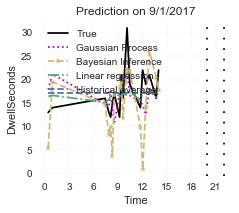

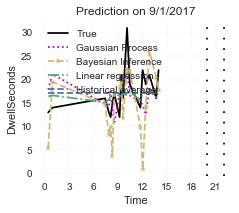

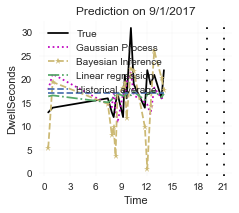

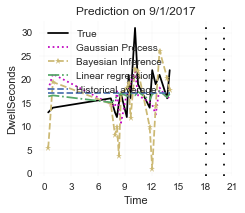

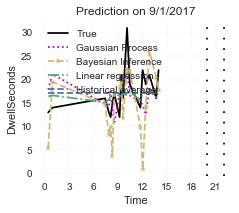

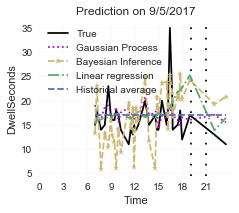

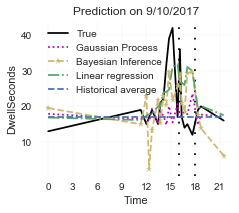

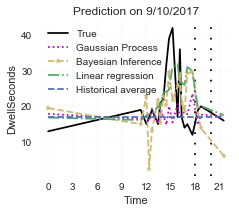

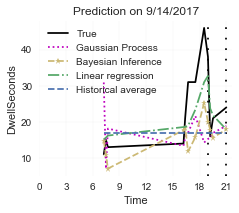

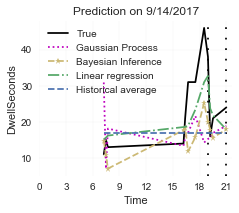

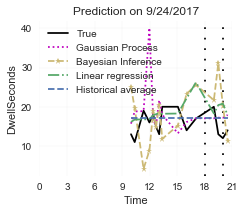

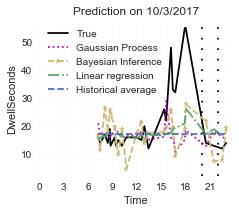

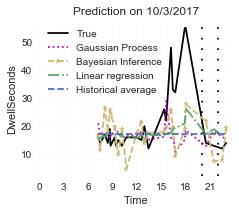

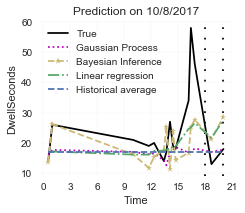

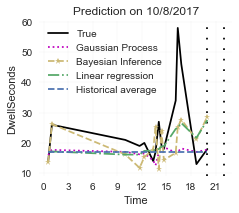

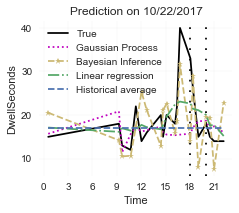

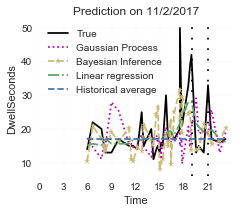

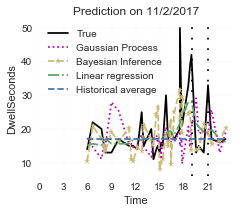

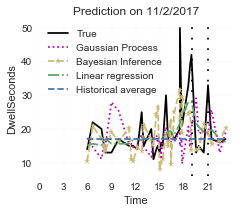

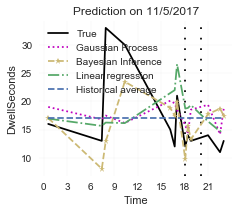

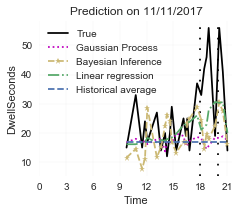

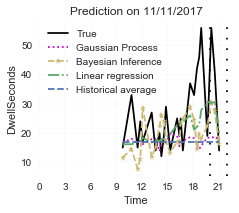

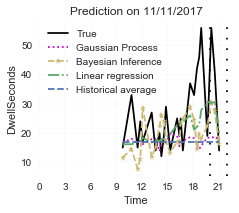

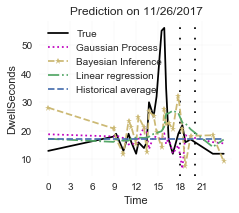

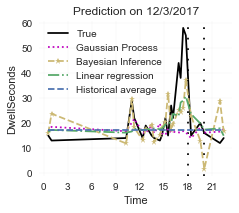

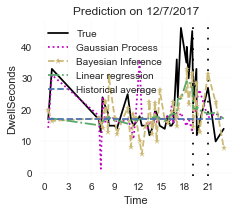

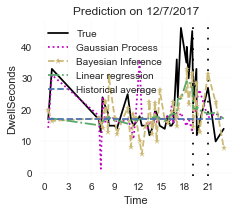

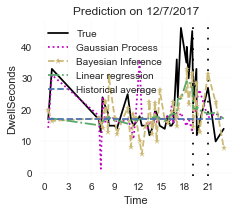

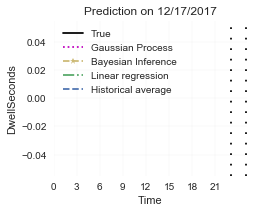

In [36]:
width = 250
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'







ev=ev[ev['venue_unique']=="Parken"]
ev=ev[ev['starting_time'].dt.month>=test.ObservedArrivalDateTime.dt.month[0]]
for date in ev.starting_time:
    da=date.day
    mo=date.month
    ho=date.hour
    ho_1=ho+2
    test_inde=test.reset_index()
    indexs=test_inde.index[(test['ObservedArrivalDateTime'].dt.month==mo) & (test['ObservedArrivalDateTime'].dt.day==da)] 

    fig, ax1 = plt.subplots(1, 1, figsize=set_size(width))
    plt.axvline(ho,c="k",linestyle=(0, (1, 5)))
    plt.axvline(ho_1,c="k",linestyle=(0, (1, 5)))
    H_min=test.iloc[indexs].ObservedArrivalDateTime.dt.hour+(test.iloc[indexs].ObservedArrivalDateTime.dt.minute)/60
    plt.plot(H_min,y_test[0][indexs],c="k", label="True")
    plt.plot(H_min,y_pred_gp[indexs],linestyle=':',c="k",color="m",label="Gaussian Process")
    plt.plot(H_min,y_hat[indexs],'--*',color="C4",label="Bayesian Inference")
    plt.plot(H_min,y_pred_lr[indexs],linestyle='-.',color="C1",label="Linear regression")
    plt.plot(H_min,np.array(hist_average)[indexs],linestyle="--",color="C6",label="Historical average")
    plt.rcParams['axes.facecolor']='white'
    plt.rcParams['savefig.facecolor']='white'
    plt.legend(loc=2)
    plt.xticks(range(0,24,3))
    plt.grid(b=True,c="grey",alpha=0.2,linewidth=0.2)
    plt.title("Prediction on %s/%s/2017"%(mo,da))
    plt.ylabel("%s"%(col_y[0]))
    plt.xlabel("Time")

    file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\pdf_single_plot\\"%(st,col_y[0])
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\png_single_plot\\"%(st,col_y[0])
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\svg_single_plot\\"%(st,col_y[0])
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

    plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\pdf_single_plot\\%s_%s.pdf"%(st,col_y[0],mo,da), format='pdf', bbox_inches='tight')
    plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\png_single_plot\\%s_%s.png"%(st,col_y[0],mo,da), format='png', bbox_inches='tight')
    plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\svg_single_plot\\%s_%s.svg"%(st,col_y[0],mo,da), format='svg', bbox_inches='tight')
    plt.show()


In [57]:
training, test, y_test,y_training,x_training,x_test=select_and_spilt(dw,678,list_col_isEvent,col_y,col_x)

y_pred_gp=gaussian_process(_n,678,list_col_isEvent,col_y,col_x )



MemoryError: 

In [ ]:
y_pred_gp

IndexError: invalid index to scalar variable.

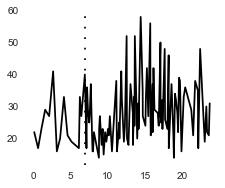

In [42]:
width = 250
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'


fig, ax1 = plt.subplots(1, 1, figsize=set_size(width))


plt.rcParams['figure.figsize'] = (8, 4)
ev=ev[ev['venue_unique']==test.PoiName.unique()[0]]
ev=ev[ev['starting_time'].dt.month>=test.ObservedArrivalDateTime.dt.month[0]]
for date in ev.starting_time:
    da=date.day
    mo=date.month
    ho=date.hour

    test_inde=test.reset_index()
    indexs=test_inde.index[(test['ObservedArrivalDateTime'].dt.month==mo) & (test['ObservedArrivalDateTime'].dt.day==da)] 
    if len(indexs)>0:
        plt.axvline(ho,c="k",linestyle=(0, (1, 5)))
        H_min=test.iloc[indexs].hours+(test.iloc[indexs].ObservedArrivalDateTime.dt.minute)/60
        plt.plot(H_min,y_test[0][indexs],c="k", label="True")
        plt.plot(H_min,y_pred_gp[indexs],linestyle=':',c="k",color="m",label="Gaussian Process")
        plt.plot(H_min,y_hat[indexs],'--*',color="C4",label="Bayesian Inference")
        plt.plot(H_min,y_pred_lr[indexs],linestyle='-.',color="C1",label="Linear regression")
        plt.plot(H_min,np.array(hist_average)[indexs],linestyle="--",color="C6",label="Historical average")
        plt.rcParams['axes.facecolor']='white'
        plt.rcParams['savefig.facecolor']='white'
        plt.legend(loc=2)
        plt.xticks(range(25))
        plt.grid(b=True,c="grey",alpha=0.2,linewidth=0.2)
        plt.title("Prediction on %s/%s/2017"%(mo,da))
        plt.ylabel("%s"%(col_y[0]))
        plt.xlabel("Time")

#         file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\pdf_single_plot\\"%(st,col_y[0])
#         directory = os.path.dirname(file_path)
#         if not os.path.exists(directory):
#             os.makedirs(directory)
#         file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\png_single_plot\\"%(st,col_y[0])
#         directory = os.path.dirname(file_path)
#         if not os.path.exists(directory):
#             os.makedirs(directory)
#         file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\svg_single_plot\\"%(st,col_y[0])
#         directory = os.path.dirname(file_path)
#         if not os.path.exists(directory):
#             os.makedirs(directory)

#         plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\pdf_single_plot\\%s_%s.pdf"%(st,col_y[0],mo,da), format='pdf', bbox_inches='tight')
#         plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\png_single_plot\\%s_%s.png"%(st,col_y[0],mo,da), format='png', bbox_inches='tight')
#         plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\svg_single_plot\\%s_%s.svg"%(st,col_y[0],mo,da), format='svg', bbox_inches='tight')
        plt.show()

In [ ]:
# list_col_isEvent=['event_2h_bef',"event_1h_bef",'event_1h_aft','event_2h_aft']
make_prediction_dw(dw, 1409, list_col_isEvent, col_y, col_x, "ADVI",ev)

In [ ]:
# list_col_isEvent=['event_during_3h_aft','event_during_4h_aft']
make_prediction_dw(dw, 50822, list_col_isEvent, col_y, col_x, "ADVI",ev)

In [ ]:
# # list_col_isEvent=["event_1h_bef",'event_1h_aft',]
# x_training,x_test,y_training =make_prediction_dw(dw, 28000, list_col_isEvent, col_y, col_x,  "ADVI",ev)

--------

# Stopping

In [25]:
model_definition_S = """

data {
    int<lower=1> T;                          // length of the time-series / len dwell time observed              // num. steps ahead to predict 
    int y[T];                               // time-series data / dwell times observed
    int<lower=1> D;                          // number of predictors / number of features
    matrix[T,D] X;                          // predictor matrix  / features without lag

}
parameters {
    real beta_y0;                            // intercepts
    vector[D] beta_y;                        // coefficients for predictors
} 

model {
    
    beta_y0 ~ cauchy(0,1);
    
     for (d in 1:D)
        beta_y[d] ~ cauchy(0,1);             // prior on the coefficients
    
    for (t in 1:T)
        y[t] ~ bernoulli_logit(beta_y0 + beta_y' * X[t]');    // likelihood
 }

"""

In [27]:
def considered_stations_dw(df):
    st_notConsidered=[50822,1547,46743	,	1410,28005,27548,46743, 30942,30941]
    station_considered=[678,  1586, 27999, 1365,   860 ]
    list_df=[]
    for st in station_considered:
        dataf=df[df['StopPointId']==st]
        list_df.append(dataf)
    only_st_considered=pd.concat(list_df)
    try:
        only_st_considered=only_st_considered.sort_values(by='TimeStep')
    except:
        only_st_considered=only_st_considered.sort_values(by='ObservedArrivalDateTime')
    return only_st_considered



In [28]:
def select_and_spilt_stopping(df,st,list_col_isEvent,col_y,col_x):
    df=df[df['StopPointId']==st]
    df.reset_index(inplace=True,drop=True)
    df['isEvent']=0
    for col in list_col_isEvent:
        df['isEvent']+=df[col]
    split=int(len(df)*2.0/3)
    training=df[:split]
    test=df[split:]
    test.reset_index(inplace=True,drop=True)
    y_test=np.array(test[col_y], ndmin=2)
    y_training=np.array(training[col_y], ndmin=2)
    col_x=col_x+list_col_isEvent
    x_training=training[training.columns.intersection(col_x)]
    x_test=test[test.columns.intersection(col_x)]
    return training, test, y_test,y_training,x_training,x_test


def h_after_start(df):
    df['event_during_1h_aft']=((df['Time_difference']>=-1)&(df['Time_difference']<0))*1
    df['event_during_2h_aft']=((df['Time_difference']>=-2)&(df['Time_difference']<-1))*1
    df['event_during_3h_aft']=((df['Time_difference']>=-3)&(df['Time_difference']<-2))*1
    df['event_during_4h_aft']=((df['Time_difference']>=-4)&(df['Time_difference']<-3))*1
    df['event_during_5h_aft']=((df['Time_difference']>=-5)&(df['Time_difference']<-4))*1
    df['event_during_6h_aft']=((df['Time_difference']>=-6)&(df['Time_difference']<-5))*1
    return df


def historical_average_stopping(training,col_y,y_test):
    start_time = time.clock()                  
    hist_average_perc=[training[col_y].mean().values[0] for i in range(len(y_test.T))]
    hist_average_bin=[]
    for stop in range(len(y_test)):
        if random.uniform(0, 1)< training[col_y].mean().values[0]:
            hist_average_bin.append(1)
        else:
            hist_average_bin.append(0) 

    score_ha=accuracy_score(y_test,hist_average_bin)
    
    f1_ha=f1_score(y_test,hist_average_bin)
    
    print(round((time.clock() - start_time)/60), "minutes")
    return hist_average_bin,hist_average_perc,score_ha,f1_ha


def logistic_regression(y_test,y_training,x_training,x_test):
    start_time = time.clock()
    LogReg=LogisticRegression()
    LogReg.fit(x_training, y_training)
    score_log=LogReg.score(x_test,y_test)
    y_Log=LogReg.predict(x_test)
    f1_log=f1_score(y_test,y_Log)
    print(round((time.clock() - start_time)/60), "minutes")
    return y_Log,score_log,f1_log


def support_vector_machine(y_test,y_training,x_training,x_test):
    start_time = time.clock()
    s=SVC()
    s.fit(x_training, y_training)
    score_svm=s.score(x_test, y_test)
    y_svm=s.predict(x_test)
    f1_svm=f1_score(y_test,y_svm)
    print(round((time.clock() - start_time)/60), "minutes")
    return score_svm,y_svm,f1_svm


def neural_network(y_test,y_training,x_training,x_test):
    start_time = time.clock()
    nn=MLPClassifier(activation='logistic')
    nn.fit(x_training, y_training)
    score_nn=nn.score(x_test, y_test)
    y_nn=nn.predict(x_test)
    f1_nn=f1_score(y_test,y_nn)
    print(round((time.clock() - start_time)/60), "minutes")
    return score_nn, y_nn,f1_nn


def decision_tree(y_test,y_training,x_training,x_test):
    start_time = time.clock()
    dt=DecisionTreeClassifier()
    dt.fit(x_training, y_training)
    score_dt=dt.score(x_test, y_test)
    y_dt=dt.predict(x_test)
    f1_dt=f1_score(y_test,y_dt)
    print(round((time.clock() - start_time)/60), "minutes")
    return score_dt, y_dt,f1_dt


def random_forest(y_test,y_training,x_training,x_test):
    start_time = time.clock()
    rf=RandomForestClassifier()
    rf.fit(x_training, y_training)
    score_rf=rf.score(x_test, y_test)
    y_rf=rf.predict(x_test)
    f1_rf=f1_score(y_test,y_rf)
    print(round((time.clock() - start_time)/60), "minutes")
    return score_rf, y_rf,f1_rf


def bayesian_S(x_training,x_test,y_training,baysian_type,y_test):
    start_time = time.clock()
    N, D = x_training.shape
    data = {'T': len(x_training),  'y': y_training.T,'D': D, 'X': x_training }
    if baysian_type=="ADVI":
        sm = pystan.StanModel(model_code=model_definition_S)
        fit = sm.vb(data=data, iter=20000, algorithm="meanfield", grad_samples=10, verbose=True)
        
        beta_y0 = pystan_utils.vb_extract_variable(fit, "beta_y0", var_type="real")
        beta_y = pystan_utils.vb_extract_variable(fit, "beta_y", var_type="vector")

        mu = beta_y0 + np.dot(x_test, beta_y.T)
        y_hat = (mu > 0).astype("int")
    if baysian_type=="MCMC":
        fit = sm.sampling(data=data, iter=1000, chains=4, algorithm="NUTS",  verbose=True)
        check_convergence(fit)
        samples = fit.extract(permuted=True)  
        beta_y0 = samples["beta_y0"].mean(axis=0)
        beta_y = samples["beta_y"].mean(axis=0)
        mu = np.mean(beta_y0.T + np.dot(X_test, beta_y.T), axis=1)
        y_hat = (mu > 0).astype("int")
    print(round((time.clock() - start_time)/60), "minutes")
    score_b=accuracy_score(y_test,y_hat)
    f1_hat=f1_score(y_test,y_hat)
    print(round((time.clock() - start_time)/60), "minutes")
    return score_b,y_hat,f1_hat

    
def scores_all(score_ha,score_log,score_svm,score_nn,score_dt,score_rf,score_b,st,f1_ha,f1_log,f1_svm,f1_nn,f1_dt,f1_rf,f1_hat):
    scores_df = pd.DataFrame({'Type': "Accuracy", 'Historical average': [score_ha], 'LogisticRegr': [score_log],'SVM': [score_svm],'nn': [score_nn],'dt': [score_dt],  'rf': [score_rf], "bayesian":[score_b]   })
    scores_df=scores_df.append(pd.DataFrame({'Type': "F1", 'Historical average': [f1_ha],  'LogisticRegr': [f1_log],'SVM': [f1_svm],'nn': [f1_nn],'dt': [f1_dt],  'rf': [f1_rf], "bayesian":[f1_hat]   }))
    scores_df.to_csv("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\ErrorsTable_all\\%s_scores_ALL_%s.csv"%(st,col_y[0]))
    return scores_df


def scores_event(score_ha,score_log,score_svm,score_nn,score_dt,score_rf,score_b,st,f1_ha,f1_log,f1_svm,f1_nn,f1_dt,f1_rf,f1_hat,test,y_log,y_svm,y_nn,y_dt,y_rf,y_hat,y_test,hist_average_bin):
    index_test=test.index[test['isEvent']>0] 
    predictions=[y_log,y_svm,y_nn,y_dt,y_rf,y_hat]
    scores=[]
    f1_l=[]
    scores.append(accuracy_score(y_test[index_test],np.array(hist_average_bin)[index_test]))
    f1_l.append(f1_score(y_test[index_test],np.array(hist_average_bin)[index_test]))
    for pred in predictions:
        scores.append(accuracy_score(y_test[index_test],pred[index_test]))
        f1_l.append(f1_score(y_test[index_test],pred[index_test]))
    scores_df = pd.DataFrame({'Type': "Accuracy",'Historical average': [scores[0]],'Logistic': [scores[1]], 'SVM': [scores[2]],'nn': [scores[3]],'dt':[ scores[4]],  'rf': [scores[5]], "bayesian":[scores[6]]   })
    scores_df=scores_df.append(pd.DataFrame({'Type': "F1", 'Historical average': [f1_l[0]],  'LogisticRegr': [f1_l[1]],'SVM': [f1_l[2]],'nn': [f1_l[3]],'dt': [f1_l[4]],  'rf': [f1_l[5]], "bayesian":[f1_l[6]]   }))
    scores_df.to_csv("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\ErrorsTable_event\\%s_scores_Event_%s.csv"%(st,col_y[0]))
    
    
def confusion_matrices_event(hist_average_bin,y_svm,y_hat,y_test,st,test):
    hist_average_bin=np.array(hist_average_bin)
    index_test=test.index[test['isEvent']>0]
    predictions_names=["Historical Average","AVM","Bayesian"]
    predictions=[hist_average_bin,y_svm,y_hat]
    i=0
    for pred in predictions:
        
        
        plt.rcParams.update(nice_fonts)

        # Using seaborn's style
        # plt.style.use('seaborn')
        width = 250
        plt.rcParams['axes.facecolor']='white'
        plt.rcParams['savefig.facecolor']='white'

        fig, ax = plt.subplots(1, 1, figsize=set_size(width))
        
        CM=confusion_matrix(y_test[index_test], pred[index_test])
        df_cm = pd.DataFrame(CM, index = [i for i in "01"], columns = [i for i in "01"])
#         plt.figure(figsize = (5,5))
        sn.heatmap(df_cm,cmap='Greys' ,annot=True, fmt="d")
        plt.xlabel('Predicted class')
        plt.ylabel('Actual class')
        plt.title(predictions_names[i])
        
        file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Output summary\\TableAndPlot\\Plot\\%s_%s\\pdf_ConfusionMatrices\\"%(st,col_y[0])
        directory = os.path.dirname(file_path)
        if not os.path.exists(directory):
            os.makedirs(directory)
        file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Output summary\\TableAndPlot\\Plot\\%s_%s\\png_ConfusionMatrices\\"%(st,col_y[0])
        directory = os.path.dirname(file_path)
        if not os.path.exists(directory):
            os.makedirs(directory)
        file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Output summary\\TableAndPlot\\Plot\\%s_%s\\svg_ConfusionMatrices\\"%(st,col_y[0])
        directory = os.path.dirname(file_path)
        if not os.path.exists(directory):
            os.makedirs(directory)
        
        plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Output summary\\TableAndPlot\\Plot\\%s_%s\\pdf_ConfusionMatrices\\Event_%s_cm.pdf"%(st,col_y[0],predictions_names[i]), format='pdf', bbox_inches='tight')
        plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Output summary\\TableAndPlot\\Plot\\%s_%s\\png_ConfusionMatrices\\Event_%s_cm.png"%(st,col_y[0],predictions_names[i]), format='png', bbox_inches='tight')
        plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Output summary\\TableAndPlot\\Plot\\%s_%s\\svg_ConfusionMatrices\\Event_%s_cm.svg"%(st,col_y[0],predictions_names[i]), format='svg', bbox_inches='tight')
        i+=1
        plt.show()
        
def confusion_matrices_all(hist_average_bin,y_log,y_svm,y_nn,y_dt,y_rf,y_hat,y_test,st):
    predictions_names=["hist_average","log","svm","nn","dt","rf","bay"]
    predictions=[hist_average_bin,y_log,y_svm,y_nn,y_dt,y_rf,y_hat]
    i=0
    for pred in predictions:
        CM=confusion_matrix(y_test, pred)
        df_cm = pd.DataFrame(CM, index = [i for i in "01"], columns = [i for i in "01"])
        plt.figure(figsize = (5,5))
        sn.heatmap(df_cm,cmap='Greys' ,annot=True, fmt="d")
        plt.xlabel('Predicted class')
        plt.ylabel('Actual class')
        
        
        file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Output summary\\TableAndPlot\\Plot\\%s_%s\\pdf_ConfusionMatrices\\"%(st,col_y[0])
        directory = os.path.dirname(file_path)
        if not os.path.exists(directory):
            os.makedirs(directory)
        file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Output summary\\TableAndPlot\\Plot\\%s_%s\\png_ConfusionMatrices\\"%(st,col_y[0])
        directory = os.path.dirname(file_path)
        if not os.path.exists(directory):
            os.makedirs(directory)
        file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Output summary\\TableAndPlot\\Plot\\%s_%s\\svg_ConfusionMatrices\\"%(st,col_y[0])
        directory = os.path.dirname(file_path)
        if not os.path.exists(directory):
            os.makedirs(directory)
        
        
        plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Output summary\\TableAndPlot\\Plot\\%s_%s\\pdf_ConfusionMatrices\\\\All_%s_cm.pdf"%(st,col_y[0],predictions_names[i]), format='pdf', bbox_inches='tight')
        plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Output summary\\TableAndPlot\\Plot\\%s_%s\\png_ConfusionMatrices\\\\All_%s_cm.png"%(st,col_y[0],predictions_names[i]), format='png', bbox_inches='tight')
        plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Output summary\\TableAndPlot\\Plot\\%s_%s\\svg_ConfusionMatrices\\\\All_%s_cm.svg"%(st,col_y[0],predictions_names[i]), format='svg', bbox_inches='tight')
        i+=1
        plt.show()
    
    
def make_prediction_Stopping(df,st,list_col_isEvent,col_y,col_x,baysian_type): 
    df=h_after_start(df)
    training, test, y_test,y_training,x_training,x_test=select_and_spilt(df,st,list_col_isEvent,col_y,col_x)
#     col_x=col_x+list_col_isEvent
#     col_x_selected=features_selecting(x_training,y_training,col_x)
#     col_x_to_save=pd.DataFrame(col_y+col_x_selected)
#     col_x_to_save.to_csv("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\Features_used_%s_%s.csv"%(st,col_y[0]))
#     training, test, y_test,y_training,x_training,x_test=select_and_spilt(df,st,list_col_isEvent,col_y,col_x_selected,False)
    y_test=y_test[0]
    y_training=y_training[0]
    print("Historical Average \t 1/7")
    hist_average_bin,hist_average_perc,score_ha,f1_ha=historical_average_stopping(training,col_y,y_test)
#     print("Logistic refression \t 2/7")
#     y_log,score_log,f1_log=logistic_regression(y_test,y_training,x_training,x_test)
    print("Support vector machine \t 3/7")
    score_svm,y_svm,f1_svm=support_vector_machine(y_test,y_training,x_training,x_test)
#     print("Neural network \t 4/7")
# #     score_nn, y_nn,f1_nn= neural_network(y_test,y_training,x_training,x_test)
#     print("Decision Tree \t 5/7")
# #     score_dt, y_dt,f1_dt=decision_tree(y_test,y_training,x_training,x_test)
#     print("Random forest \t 6/7")
# #     score_rf, y_rf,f1_rf=random_forest(y_test,y_training,x_training,x_test)
#     print("Bayesian \t 7/7")
    score_b,y_hat,f1_hat=bayesian_S(x_training,x_test,y_training,baysian_type,y_test)
    
    
#     scores_all(score_ha,score_log,score_svm,score_nn,score_dt,score_rf,score_b,st,f1_ha,f1_log,f1_svm,f1_nn,f1_dt,f1_rf,f1_hat)
#     scores_event(score_ha,score_log,score_svm,score_nn,score_dt,score_rf,score_b,st,f1_ha,f1_log,f1_svm,f1_nn,f1_dt,f1_rf,f1_hat,test,y_log,y_svm,y_nn,y_dt,y_rf,y_hat,y_test,hist_average_bin)
#     confusion_matrices_all(hist_average_bin,y_log,y_svm,y_nn,y_dt,y_rf,y_hat,y_test,st)
    confusion_matrices_event(hist_average_bin,y_svm,y_hat,y_test,st,test)

In [29]:
# Dwell time dataset
f1 = open("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Python Files\\Files\\FinalDFs\\Dwell_2017_w", 'rb')
dw = pickle.load(f1)
f1.close()


dw=dw[dw['DwellSeconds']<60]


dw["isStopping"]=(dw["DwellSeconds"]>0)*1
dw["isStopping_lag1"]=(dw["DwellSeconds_lag1"]>0)*1
dw["isStopping_lag2"]=(dw["DwellSeconds_lag2"]>0)*1
dw["isStopping_lag3"]=(dw["DwellSeconds_lag3"]>0)*1


dw=considered_stations_dw(dw)

In [30]:
dw['isEvent']=0
dw['isEvent'][(dw['Time_difference']<6)&(dw['Time_difference']>-6)]=1

In [31]:
col_y=['isStopping']
col_x=[
    "isStopping_lag1", "isStopping_lag2","isStopping_lag3",
    'DwellSeconds_lag1', 'DwellSeconds_lag2', 'DwellSeconds_lag3',
#     'Alternative&Punk_Music', 'Classic_Music','Electronica_Music','Metal_Music', 'Urban_Music',
#     'Business', 'Children', 'Culture', 'Football', 'Medicine','Pop_Music', 'Rock_Music',                                 
#     'Music',
#     'isWeekend',
    'H0_4', 'H4_8', 'H8_12', 'H12_16', 'H16_20', 'H20_24',
#     'Precipitation','Temperature'
]


list_col_isEvent=[ 'event_1h_aft','event_1h_bef', 'event_2h_aft', 'event_2h_bef', 'event_3h_aft','event_3h_bef','event_during_1h_aft', 'event_during_2h_aft','event_during_3h_aft', 'event_during_4h_aft','event_during_5h_aft', 'event_during_6h_aft']

Historical Average 	 1/7
0 minutes
Support vector machine 	 3/7


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8ae648610837beb8c8127c1968b5083c NOW.


0 minutes


6 minutes
6 minutes


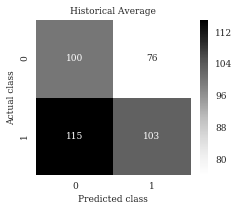

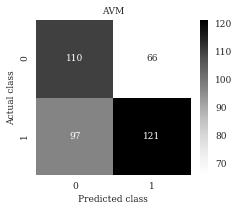

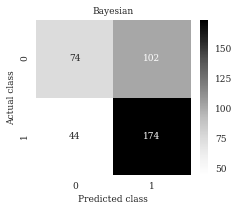

Historical Average 	 1/7
0 minutes
Support vector machine 	 3/7


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8ae648610837beb8c8127c1968b5083c NOW.


3 minutes


14 minutes
14 minutes


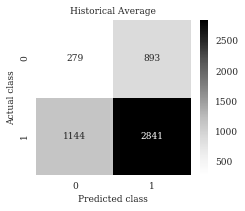

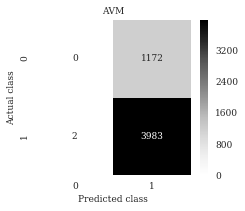

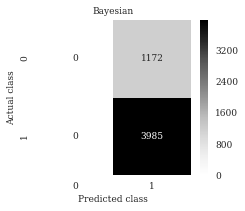

Historical Average 	 1/7
0 minutes
Support vector machine 	 3/7


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8ae648610837beb8c8127c1968b5083c NOW.


4 minutes


16 minutes
16 minutes


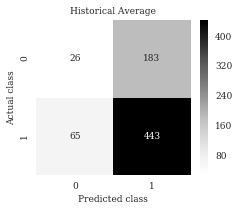

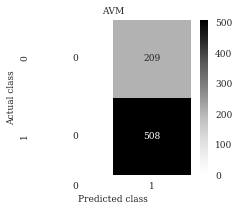

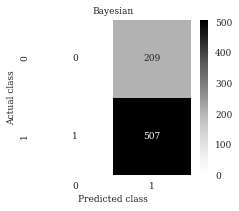

Historical Average 	 1/7
1 minutes
Support vector machine 	 3/7


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8ae648610837beb8c8127c1968b5083c NOW.


4 minutes


13 minutes
13 minutes


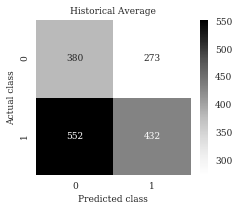

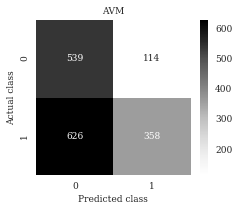

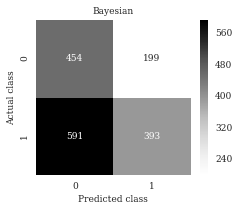

Historical Average 	 1/7
0 minutes
Support vector machine 	 3/7


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8ae648610837beb8c8127c1968b5083c NOW.


0 minutes


6 minutes
6 minutes


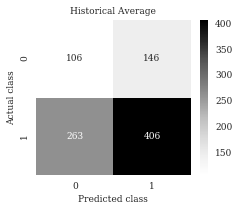

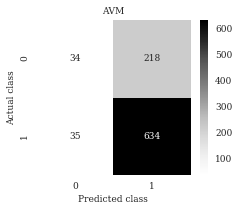

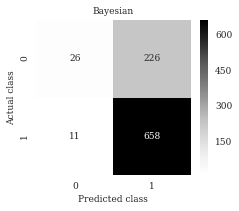

In [32]:
for st in dw.StopPointId.unique():
    make_prediction_Stopping(dw,st,list_col_isEvent,col_y,col_x,"ADVI")

In [ ]:
make_prediction_Stopping(dw,1365,list_col_isEvent,col_y,col_x,"ADVI")

In [ ]:
make_prediction_Stopping(dw,1366,list_col_isEvent,col_y,col_x,"ADVI")

In [ ]:
make_prediction_Stopping(dw,1409,list_col_isEvent,col_y,col_x,"ADVI")

In [ ]:
make_prediction_Stopping(dw,50822,list_col_isEvent,col_y,col_x,"ADVI")

-------

# Stopping and Dwell times

In [ ]:
def support_vector_machine_prob(y_test,y_training,x_training,x_test):
    start_time = time.clock()
    s=SVC(probability=True)
    s.fit(x_training, y_training)
    y_svm_prob=s.predict_proba(x_test)
    print(round((time.clock() - start_time)/60), "minutes")
    return y_svm_prob


def linear_regression_SD(x_traing,x_test,y_training ):
    start_time = time.clock()
    x_traing=np.c_[np.ones(len(x_traing)),x_traing]
    x_test=np.c_[np.ones(len(x_test)),x_test]
    regr=linear_model.LinearRegression(fit_intercept=False)   
    regr.fit(x_traing, y_training);
    y_pred_lr=regr.predict(x_test)
    y_pred_lr[y_pred_lr<0]=0
    print(round((time.clock() - start_time)/60), "minutes")
    return y_pred_lr


def errors_table_event_SD(y_test,hist_average_stop_dw,svm_lr_stop_dw,test,st):
    test_inde=test.reset_index()
    index_test=test_inde.index[test_inde['isEvent']>0] 
    mae, rae, rmse, r2 = compute_error(y_test[:,0][index_test], np.array(hist_average_stop_dw)[index_test])
    errors=pd.DataFrame({'Model': ["Historical Average"], 'mae': [mae],'rae': [rae],'rmse': [rmse],  'r2': [r2]   })
    mae, rae, rmse, r2=compute_error(y_test[:,0][index_test], svm_lr_stop_dw[index_test])
    errors=errors.append(pd.DataFrame({'Model': ["Linear Regression"], 'mae': [mae],'rae': [rae],'rmse': [rmse],  'r2': [r2]   }))
    col_y=['Dwell_second_weighted']
    errors.to_csv("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\ErrorsTable_event\\%s_event_%s.csv"%(st,col_y[0]))

    
def errors_table_all_SD(y_test,hist_average_stop_dw,svm_lr_stop_dw,test,st):
    mae, rae, rmse, r2 = compute_error(y_test[:,0], hist_average_stop_dw)
    errors=pd.DataFrame({'Model': ["Historical Average"], 'mae': [mae],'rae': [rae],'rmse': [rmse],  'r2': [r2]   })
    mae, rae, rmse, r2=compute_error(y_test[:,0], svm_lr_stop_dw)
    errors=errors.append(pd.DataFrame({'Model': ["Linear Regression"], 'mae': [mae],'rae': [rae],'rmse': [rmse],  'r2': [r2]   }))
    col_y=['Dwell_second_weighted']
    errors.to_csv("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\ErrorsTable_all\\%s_all_%s.csv"%(st,col_y[0]))


def plotting_unique_dw(y_test, svm_lr_stop_dw, hist_average_stop_dw,test,st,ev,col_y):
    plt.rcParams['figure.figsize'] = (8, 4)
    ev=ev[ev['venue_unique']==test.PoiName.unique()[0]]
    ev=ev[ev['starting_time'].dt.month>=test.ObservedArrivalDateTime.dt.month[0]]
    for date in ev.starting_time:
        da=date.day
        mo=date.month
        ho=date.hour

        test_inde=test.reset_index()
        indexs=test_inde.index[(test['ObservedArrivalDateTime'].dt.month==mo) & (test['ObservedArrivalDateTime'].dt.day==da)] 
        if len(indexs)>0:
            plt.axvline(ho,c="k",linestyle=(0, (1, 5)))
            H_min=test.iloc[indexs].hours+(test.iloc[indexs].ObservedArrivalDateTime.dt.minute)/60
            plt.plot(H_min,y_test[:,0][indexs],c="k", label="True")
            plt.plot(H_min,svm_lr_stop_dw[indexs],linestyle='-.',color="C1",label="Linear regression")
            plt.plot(H_min,np.array(hist_average_stop_dw)[indexs],linestyle="--",color="C6",label="Historical average")
            plt.rcParams['axes.facecolor']='white'
            plt.rcParams['savefig.facecolor']='white'
            plt.legend(loc=2)
            plt.xticks(range(25))
            plt.grid(b=True,c="grey",alpha=0.2,linewidth=0.2)
            plt.title("Prediction on %s/%s/2017"%(mo,da))
            plt.ylabel("%s"%(col_y[0]))
            plt.xlabel("Time")
            col_y=['Dwell_second_weighted']
        
            file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\pdf_single_plot\\"%(st,col_y[0])
            directory = os.path.dirname(file_path)
            if not os.path.exists(directory):
                os.makedirs(directory)
            file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\png_single_plot\\"%(st,col_y[0])
            directory = os.path.dirname(file_path)
            if not os.path.exists(directory):
                os.makedirs(directory)
            file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\svg_single_plot\\"%(st,col_y[0])
            directory = os.path.dirname(file_path)
            if not os.path.exists(directory):
                os.makedirs(directory)

            plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\pdf_single_plot\\%s_%s.pdf"%(st,col_y[0],mo,da), format='pdf', bbox_inches='tight')
            plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\png_single_plot\\%s_%s.png"%(st,col_y[0],mo,da), format='png', bbox_inches='tight')
            plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\svg_single_plot\\%s_%s.svg"%(st,col_y[0],mo,da), format='svg', bbox_inches='tight')
            plt.show()
            
            
def plotting_45degree(y_testD, svm_lr_stop_dw, hist_average_stop_dw,test,st,ev,col_y):          
    models=[np.array(hist_average_stop_dw),svm_lr_stop_dw]
    labels=["---","Historical Average","Linear Regression", "Gaussian Process","Bayesian Inference"]
    i =0
    for mo in models:
        i+=1
        plt.rcParams['figure.figsize'] = (6, 6)
        plt.scatter(y_test[0],mo,s=10)
        yLim=max(y_testD[0])
        plt.ylim(-2,yLim+2)
        plt.xlim(-2,yLim+2)
        plt.plot([-2,yLim+2], [-2,yLim+2], ls="--", c=".3",alpha=0.5)
        plt.xlabel("True")
        plt.ylabel("%s"%(labels[i]))
        plt.title("True values - Forecast")
        
        file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\pdf_45Degree\\"%(st,col_y[0])
        directory = os.path.dirname(file_path)
        if not os.path.exists(directory):
            os.makedirs(directory)
        file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\png_45Degree\\"%(st,col_y[0])
        directory = os.path.dirname(file_path)
        if not os.path.exists(directory):
            os.makedirs(directory)
        file_path = "C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\svg_45Degree\\"%(st,col_y[0])
        directory = os.path.dirname(file_path)
        if not os.path.exists(directory):
            os.makedirs(directory)

        plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\pdf_45Degree\\%s_%s.pdf"%(st,col_y[0],st,col_y[0]), format='pdf', bbox_inches='tight')
        plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\png_45Degree\\%s_%s.png"%(st,col_y[0],st,col_y[0]), format='png', bbox_inches='tight')
        plt.savefig("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\TableAndPlot\\Plot\\%s_%s\\svg_45Degree\\%s_%s.svg"%(st,col_y[0],st,col_y[0]), format='svg', bbox_inches='tight')
        plt.show()


def make_prediction_Stopping_DW(df,st,list_col_isEvent,col_y,col_x): 
    col_yS=["isStopping"] 
    df=h_after_start(df)
    training, test, y_test,y_training,x_training,x_test=select_and_spilt(df,st,list_col_isEvent,col_y,col_x,True)
    col_x=col_x+list_col_isEvent
    col_x_selected=features_selecting(x_training,y_training,col_x)
    col_x_to_save=pd.DataFrame(col_y+col_x_selected)
    col_x_to_save.to_csv("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Results\\%s_%s.csv"%(st,col_y[0]))
    training, test, y_test,y_training,x_training,x_test=select_and_spilt(df,st,list_col_isEvent,col_y,col_x_selected,False)
    y_test=y_test[0]
    y_training=y_training[0]
    hist_average_bin,hist_average_perc,score_ha,f1_ha=historical_average_stopping(training,col_y,y_test)
    y_svm_prob=support_vector_machine_prob(y_test,y_training,x_training,x_test)
    col_yD=["DwellSeconds"]
    y_trainingD=np.array(training[col_yD], ndmin=2)
    y_testD=np.array(test[col_yD], ndmin=2)
    hist_averageD=historical_average_poor(training,col_yD,test)
    y_pred_lr=linear_regression_SD(x_training,x_test,y_trainingD)
    hist_average_stop_dw=[hist_averageD[0]*hist_average_perc[0]]*len(hist_averageD)
    svm_lr_stop_dw=y_svm_prob[:,1]*y_pred_lr[:,0]
    svm_lr_stop_dw.clip(min=0)
    col_y=['Dwell_second_weighted']
    errors_table_event_SD(y_testD,hist_average_stop_dw,svm_lr_stop_dw,test,st)
    errors_table_all_SD(y_testD,hist_average_stop_dw,svm_lr_stop_dw,test,st)
    plotting_unique_dw(y_testD, svm_lr_stop_dw, hist_average_stop_dw,test,st,ev,col_y)
    plotting_45degree(y_testD, svm_lr_stop_dw, hist_average_stop_dw,test,st,ev,col_y)
    


In [ ]:
# Dwell time dataset
f1 = open("C:\\Users\\User\\Desktop\\DTU\\Thesis\\Python Files\\Files\\FinalDFs\\Dwell_2017_w", 'rb')
dw = pickle.load(f1)
f1.close()

dw=dw[dw['DwellSeconds']<60]

dw["isStopping"]=(dw["DwellSeconds"]>0)*1
dw["isStopping_lag1"]=(dw["DwellSeconds_lag1"]>0)*1
dw["isStopping_lag2"]=(dw["DwellSeconds_lag2"]>0)*1
dw["isStopping_lag3"]=(dw["DwellSeconds_lag3"]>0)*1

col_y=['isStopping']
col_x=[
    "isStopping_lag1", "isStopping_lag2","isStopping_lag3",
    'DwellSeconds_lag1', 'DwellSeconds_lag2', 'DwellSeconds_lag3',
       'Alternative&Punk_Music', 'Alternative_Music','Classic_Music','Electronica_Music','Metal_Music', 'Urban_Music',
    'Business', 'Children',  'Comedy', 'Culture', 'Football', 'Gaming', 'Medicine', 'Music_Festival','Pop_Music', 'Rock_Music', 'Theater',                                 
       'Music',
       'isWeekend','h_0', 'h_1', 'h_2','h_3', 'h_4', 'h_5', 'h_6', 'h_7', 'h_8', 'h_9', 'h_10', 'h_11', 'h_12','h_13', 'h_14', 'h_15', 'h_16', 'h_17', 'h_18', 'h_19', 'h_20', 'h_21','h_22', 'h_23',                          
    'Precipitation','Temperature',
       ]


list_col_isEvent=[ 'event_1h_aft','event_1h_bef', 'event_2h_aft', 'event_2h_bef', 'event_3h_aft','event_3h_bef','event_during_1h_aft', 'event_during_2h_aft','event_during_3h_aft', 'event_during_4h_aft','event_during_5h_aft', 'event_during_6h_aft']

In [ ]:
make_prediction_Stopping_DW(dw,1365,list_col_isEvent,col_y,col_x)

In [ ]:
make_prediction_Stopping_DW(dw,1409,list_col_isEvent,col_y,col_x)

In [ ]:
make_prediction_Stopping_DW(dw,50822,list_col_isEvent,col_y,col_x)

In [ ]:
make_prediction_Stopping_DW(dw,28000,list_col_isEvent,col_y,col_x)